In [ ]:
import pandas as pd


In [2]:
merged = pd.read_parquet('merged_eth_usdt_vwap_oct2025.parquet', engine = 'pyarrow')
merged.dropna(inplace = True)
merged

,dex_price,cex_price
timestamp,,
1759276800000,4147.802786,4145.285621
1759276803000,4143.787639,4145.339682
1759276806000,4143.689566,4146.557793
1759276809000,4148.503567,4146.364820
1759276812000,4148.289107,4146.678950
...,...,...
1761954255000,3858.177483,3857.259093
1761954267000,3858.239828,3857.645999
1761954306000,3858.445123,3858.569559


/opt/anaconda3/lib/python3.12/site-packages/darts/timeseries.py:5145: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_times = resampled_times.asfreq(freq)
/opt/anaconda3/lib/python3.12/site-packages/darts/timeseries.py:5145: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_times = resampled_times.asfreq(freq)


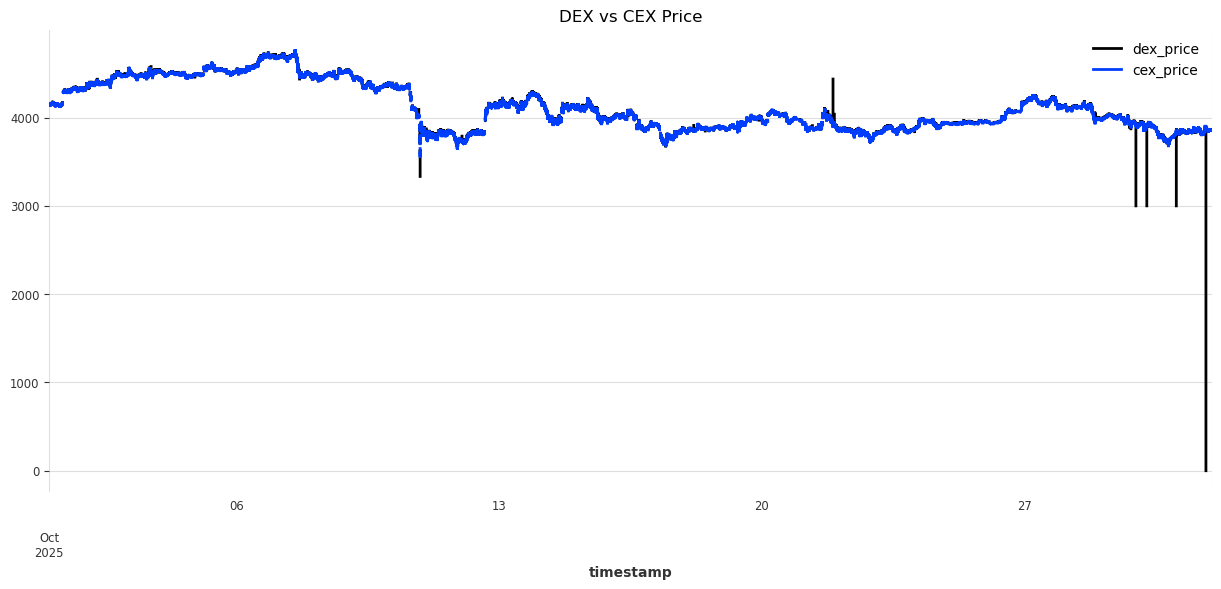

In [3]:
from darts import TimeSeries
import matplotlib.pyplot as plt

# Ensure index is sorted and in datetime format
merged.sort_index(inplace=True)
if not isinstance(merged.index, pd.DatetimeIndex):
    merged.index = pd.to_datetime(merged.index, unit='ms')

# Create TimeSeries objects
# We set fill_missing_dates=True and freq='3S' to handle potential gaps in the data
ts_dex = TimeSeries.from_dataframe(merged, value_cols='dex_price', fill_missing_dates=True, freq='3S')
ts_cex = TimeSeries.from_dataframe(merged, value_cols='cex_price', fill_missing_dates=True, freq='3S')

# Plot the two price series
plt.figure(figsize=(15, 6))
ts_dex.plot(label='dex_price')
ts_cex.plot(label='cex_price')
plt.title('DEX vs CEX Price')
plt.show()

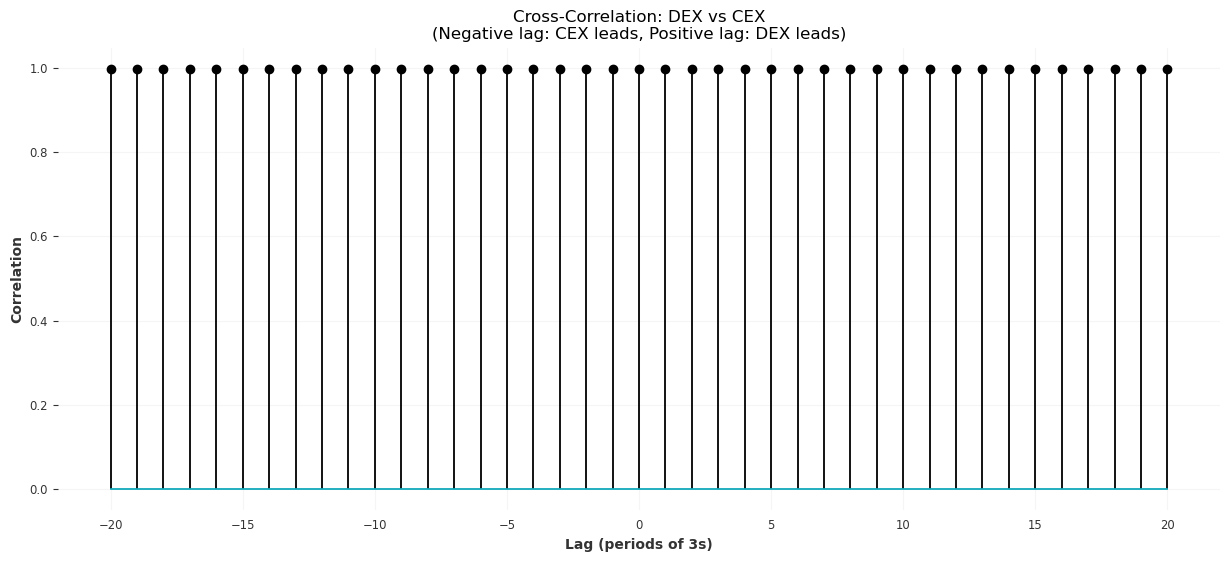

Maximum correlation is at lag 0 (periods of 3s)


In [4]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

# Prepare data for analysis
# We use the TimeSeries objects to ensure we have a regular frequency (filled gaps)
# Convert back to pandas for statsmodels
df_dex = ts_dex.to_dataframe()
df_cex = ts_cex.to_dataframe()
df_filled = pd.concat([df_dex, df_cex], axis=1)

# Fill any NaNs introduced by filling missing dates (using forward fill for prices)
df_filled.ffill(inplace=True)
df_filled.dropna(inplace=True)

# 1. Cross-Correlation Analysis
# Calculate correlation for different lags
def cross_correlation(data_x, data_y, lag=0):
    return data_x.corr(data_y.shift(lag))

lags_range = range(-20, 21)
corrs = [cross_correlation(df_filled['dex_price'], df_filled['cex_price'], lag) for lag in lags_range]

plt.figure(figsize=(15, 6))
plt.stem(lags_range, corrs)
plt.title('Cross-Correlation: DEX vs CEX\n(Negative lag: CEX leads, Positive lag: DEX leads)')
plt.xlabel('Lag (periods of 3s)')
plt.ylabel('Correlation')
plt.grid(True, alpha=0.3)
plt.show()

# Find the lag with maximum correlation
max_corr_idx = np.argmax(corrs)
best_lag = lags_range[max_corr_idx]
print(f"Maximum correlation is at lag {best_lag} (periods of 3s)")

In [5]:
# 2. Granger Causality
# Granger Causality requires stationary time series.
# Prices are typically non-stationary, so we should use returns (differenced data).

# Calculate percentage returns to make the series stationary
df_returns = df_filled[['dex_price', 'cex_price']].pct_change()

# Replace infinite values with NaN and drop them (in case of division by zero)
df_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
df_returns.dropna(inplace=True)

max_lag = 10

print(f"\nGranger Causality: Does CEX cause DEX? (checking lags 1 to {max_lag})")
# (target, predictor) -> (DEX, CEX)
# We check if CEX returns Granger-cause DEX returns
gc_res_cex_leads = grangercausalitytests(df_returns[['dex_price', 'cex_price']], maxlag=max_lag, verbose=True)

print(f"\n{'='*50}\n")

print(f"Granger Causality: Does DEX cause CEX? (checking lags 1 to {max_lag})")
# (target, predictor) -> (CEX, DEX)
# We check if DEX returns Granger-cause CEX returns
gc_res_dex_leads = grangercausalitytests(df_returns[['cex_price', 'dex_price']], maxlag=max_lag, verbose=True)


Granger Causality: Does CEX cause DEX? (checking lags 1 to 10)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=70.1184 , p=0.0000  , df_denom=892507, df_num=1
ssr based chi2 test:   chi2=70.1186 , p=0.0000  , df=1
likelihood ratio test: chi2=70.1158 , p=0.0000  , df=1


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


parameter F test:         F=70.1184 , p=0.0000  , df_denom=892507, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=71.7437 , p=0.0000  , df_denom=892504, df_num=2
ssr based chi2 test:   chi2=143.4882, p=0.0000  , df=2
likelihood ratio test: chi2=143.4767, p=0.0000  , df=2
parameter F test:         F=71.7437 , p=0.0000  , df_denom=892504, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=108.3032, p=0.0000  , df_denom=892501, df_num=3
ssr based chi2 test:   chi2=324.9121, p=0.0000  , df=3
likelihood ratio test: chi2=324.8529, p=0.0000  , df=3
parameter F test:         F=108.3032, p=0.0000  , df_denom=892501, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=123.3555, p=0.0000  , df_denom=892498, df_num=4
ssr based chi2 test:   chi2=493.4271, p=0.0000  , df=4
likelihood ratio test: chi2=493.2907, p=0.0000  , df=4
parameter F test:         F=123.3555, p=0.0000  , df_denom=892498, df_num=4


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=9.6952  , p=0.0018  , df_denom=892507, df_num=1
ssr based chi2 test:   chi2=9.6952  , p=0.0018  , df=1
likelihood ratio test: chi2=9.6952  , p=0.0018  , df=1
parameter F test:         F=9.6952  , p=0.0018  , df_denom=892507, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3204  , p=0.0018  , df_denom=892504, df_num=2
ssr based chi2 test:   chi2=12.6410 , p=0.0018  , df=2
likelihood ratio test: chi2=12.6409 , p=0.0018  , df=2
parameter F test:         F=6.3204  , p=0.0018  , df_denom=892504, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.4622  , p=0.0039  , df_denom=892501, df_num=3
ssr based chi2 test:   chi2=13.3866 , p=0.0039  , df=3
likelihood ratio test: chi2=13.3865 , p=0.0039  , df=3
parameter F test:         F=4.4622  , p=0.0039  , df_denom=892501, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7297  , p=0.0049  , df_denom=892498, df_num=4


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 03, Dec, 2025
Time:                     21:48:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -29.8824
Nobs:                     892496.    HQIC:                  -29.8830
Log likelihood:       1.08026e+07    FPE:                1.05170e-13
AIC:                     -29.8832    Det(Omega_mle):     1.05162e-13
--------------------------------------------------------------------
Results for equation dex_price
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000001         0.000001           -0.617           0.537
L1.dex_price         -0.008612         0.001072           -8.036           0.000
L1.cex_price          0.054383         0.006387         

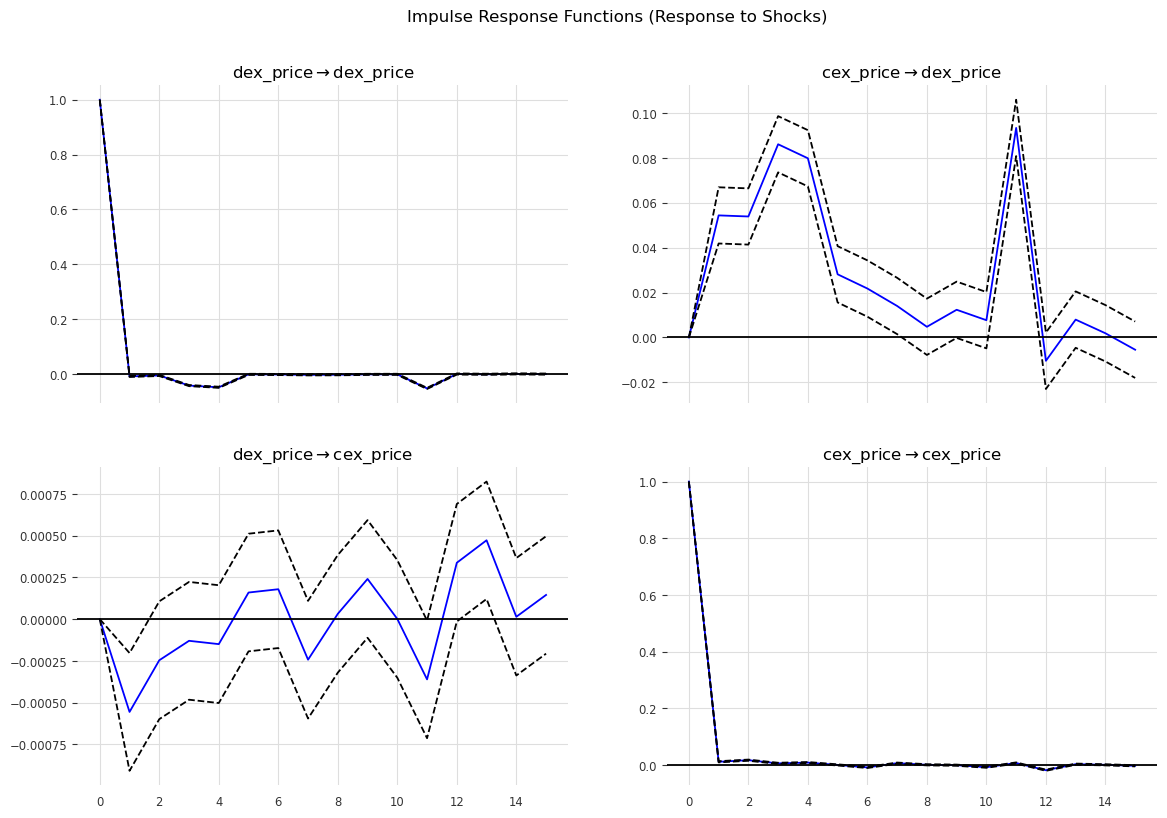

In [6]:
from statsmodels.tsa.api import VAR

# 4. VAR Model & Impulse Response Analysis
# We fit a VAR model on the RETURNS (stationary data) to see short-term dynamics.

model = VAR(df_returns)
# Automatically select lag order based on AIC
results = model.fit(maxlags=15, ic='aic')
print(results.summary())

# Plot Impulse Response Functions (IRF)
# This shows: If DEX price jumps, what happens to CEX price over the next N steps? (and vice versa)
irf = results.irf(15)
irf.plot(orth=False, figsize=(12, 8))
plt.suptitle('Impulse Response Functions (Response to Shocks)', y=1.02)
plt.show()



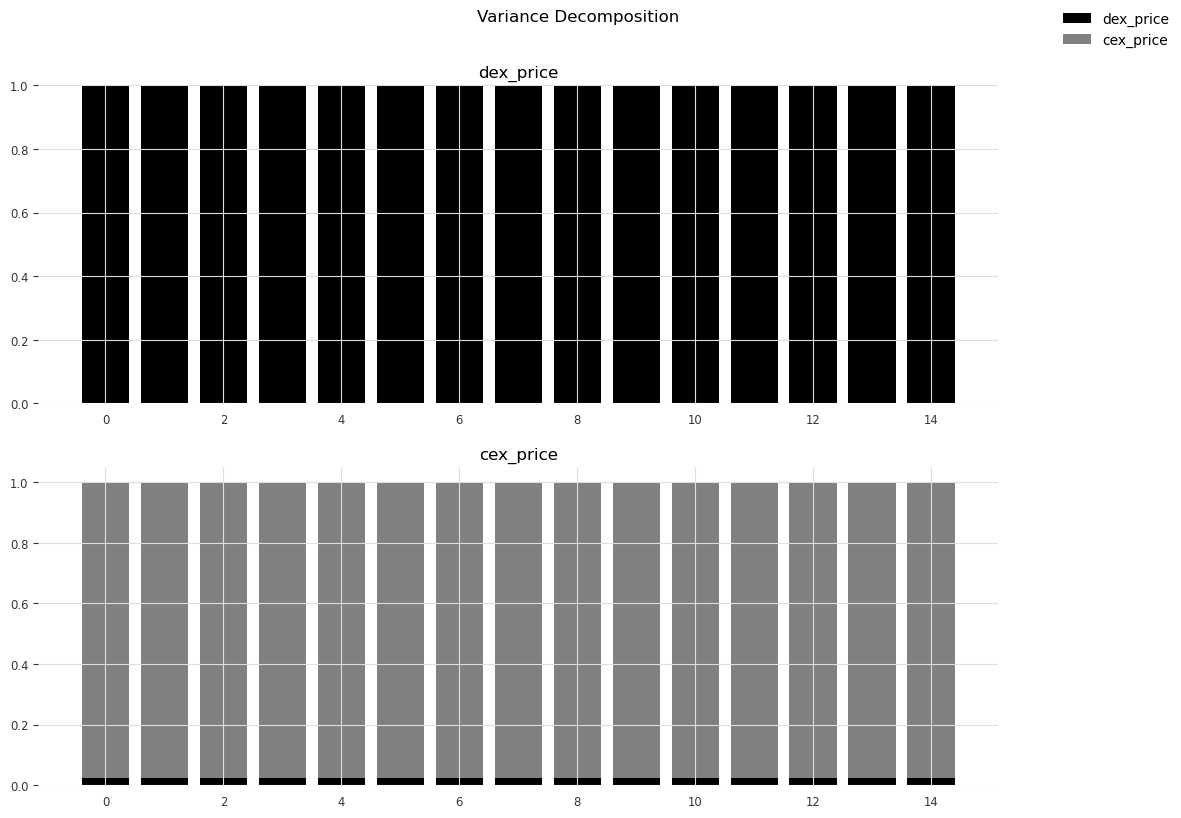

In [7]:
# Variance Decomposition
# This shows: How much of the future variation in DEX price is explained by CEX price?
fevd = results.fevd(15)
fevd.plot(figsize=(12, 8))
plt.suptitle('Variance Decomposition', y=1.02)
plt.show()

### Interpretation of Variance Decomposition Plot

This plot shows how much of the future uncertainty (variance) in one market's price can be explained by the other market.

*   **Top Graph (`dex_price`)**:
    *   The bars are almost **100% Black** (`dex_price`).
    *   **Meaning**: The DEX price is almost entirely driven by its own shocks. Shocks to the CEX price (Gray) explain almost **0%** of the variation in the DEX price.
    *   **Implication**: In this model, the DEX appears to be "exogenous" or independent; it moves based on its own information and ignores the CEX in the short term.

*   **Bottom Graph (`cex_price`)**:
    *   The bars are **mostly Gray** (`cex_price`) with a **tiny sliver of Black** (`dex_price`) at the bottom.
    *   **Meaning**: The CEX price is also mostly driven by itself, but the DEX price explains a very small fraction (perhaps 1-2%) of its variance.
    *   **Implication**: The CEX is slightly influenced by the DEX, but the effect is very weak.

**Overall Conclusion from this Plot:**
The variance decomposition suggests that **neither market strongly drives the other in the short term**. They are largely independent in their volatility.

*Note: This might seem to contradict the Granger Causality test (which showed a relationship). Granger causality tests if past values help *predict* future values (statistical significance), while Variance Decomposition measures *how much* of the movement is explained (magnitude/strength). Here, the relationship might be statistically significant but weak in magnitude.*

In [8]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# 3. Cointegration Test (Johansen)
# We test on the RAW prices (df_filled), not returns, to check for long-run relationship.
print("Running Johansen Cointegration Test...")

# det_order=0 (constant term), k_ar_diff=1 (lag order)
johan_test = coint_johansen(df_filled[['dex_price', 'cex_price']], det_order=0, k_ar_diff=1)

# Helper to interpret results
def interpret_johansen(test_result):
    print(f"{'Hypothesis':<20} {'Trace Stat':<15} {'95% Critical Val':<20} {'Result'}")
    print("-" * 65)
    for i in range(len(test_result.lr1)):
        trace_stat = test_result.lr1[i]
        crit_val = test_result.cvt[i, 1]  # 1 is the index for 95% confidence
        hypothesis = f"r <= {i}"
        result = "Significant (Cointegration)" if trace_stat > crit_val else "Not Significant"
        print(f"{hypothesis:<20} {trace_stat:<15.4f} {crit_val:<20.4f} {result}")

interpret_johansen(johan_test)

Running Johansen Cointegration Test...
Hypothesis           Trace Stat      95% Critical Val     Result
-----------------------------------------------------------------
r <= 0               65854.6740      15.4943              Significant (Cointegration)
r <= 1               2.3420          3.8415               Not Significant


### Interpretation of Johansen Test Results

*   **`r <= 0` (Significant)**: The test statistic (65854) is much greater than the critical value (15.49). We **reject** the null hypothesis that there are 0 cointegrating relationships. This means there is **at least one** long-term relationship binding these two prices together.
*   **`r <= 1` (Not Significant)**: The test statistic (2.34) is less than the critical value (3.84). We **cannot reject** the null hypothesis that there is 1 cointegrating relationship.

**Conclusion:** There is **exactly 1 cointegrating relationship** between the DEX and CEX prices.
*   This confirms that although the prices might diverge in the short term (creating arbitrage opportunities), they are statistically tied together in the long run.
*   They move together and do not drift apart indefinitely.
*   **Implication**: Since they are cointegrated, a **Vector Error Correction Model (VECM)** is theoretically more appropriate than a standard VAR on returns, as VECM models both the short-term dynamics *and* the adjustment back to the long-term equilibrium.

### Synthesis: What is the relationship?

Combining these four results gives us a nuanced picture of the DEX-CEX relationship:

1.  **They are fundamentally tied together (Johansen Cointegration)**:
    *   Think of the two prices as being connected by a **rubber band**.
    *   While they can wander apart in the short term, they cannot drift apart forever. Arbitrageurs eventually step in to close the gap. This is the strongest finding: they share a common long-term trend.

2.  **Price discovery is shared, not dominated (Bidirectional Granger Causality)**:
    *   It is **not** a simple "Leader-Follower" relationship where the CEX moves and the DEX just copies it (or vice versa).
    *   Information flows **both ways**. Events on the DEX influence the CEX, and events on the CEX influence the DEX. Both markets contribute to finding the "true" price of ETH.

3.  **Short-term volatility is local (Weak Variance Decomposition)**:
    *   This is the surprising part. Even though they track each other, a sudden "shock" (volatility spike) in one market does **not** immediately cause a massive panic in the other.
    *   The DEX's volatility is mostly driven by DEX-specific factors (e.g., block inclusion, liquidity pool mechanics), and the CEX's volatility is driven by CEX factors (e.g., order book depth, high-frequency traders).

**Conclusion:**
The markets are **coupled but noisy**.
*   **Long Run**: Highly efficient arbitrage keeps them aligned.
*   **Short Run**: They are somewhat insulated from each other's *noise*. The "signal" (price level) transfers between them, but the "noise" (variance) stays local.



Resampling data to 5-minute frequency for VECM...
New shape: (8926, 2)
Fitting VECM Model...
Det. terms outside the coint. relation & lagged endog. parameters for equation dex_price
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.dex_price     -0.2863      0.023    -12.589      0.000      -0.331      -0.242
L1.cex_price      0.4114      0.030     13.581      0.000       0.352       0.471
L2.dex_price     -0.1464      0.023     -6.490      0.000      -0.191      -0.102
L2.cex_price      0.1938      0.031      6.318      0.000       0.134       0.254
L3.dex_price     -0.0572      0.022     -2.587      0.010      -0.101      -0.014
L3.cex_price      0.2161      0.030      7.125      0.000       0.157       0.276
L4.dex_price      0.0051      0.022      0.235      0.814      -0.037       0.048
L4.cex_price      0.0616      0.030      2.050      0.040       0.003       0.12

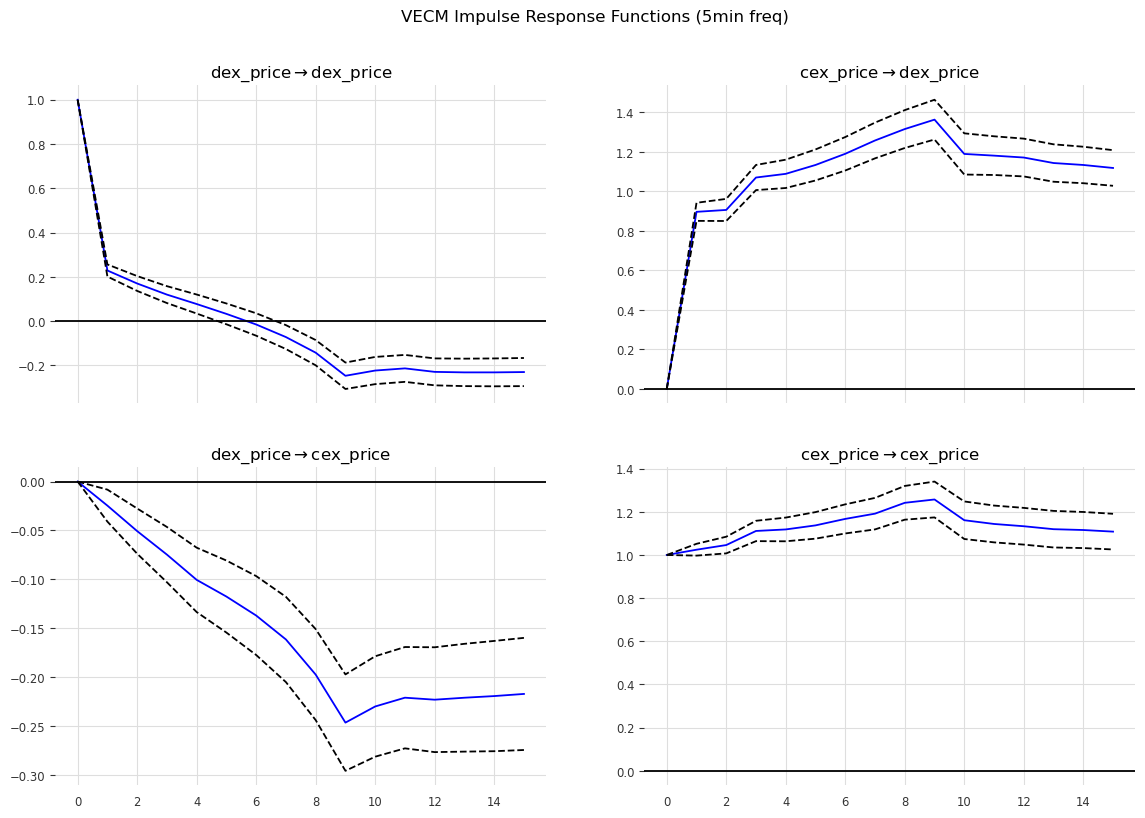

In [9]:
from statsmodels.tsa.vector_ar.vecm import VECM

# 5. Vector Error Correction Model (VECM)
# MEMORY FIX: The dataset is too large (~900k rows) for statsmodels' VECM implementation
# which creates a TxT matrix (requiring ~5.8 TB RAM).
# We must resample the data to a lower frequency (e.g., 5 minutes) to make it computationally feasible.

print("Resampling data to 5-minute frequency for VECM...")
df_vecm = df_filled[['dex_price', 'cex_price']].resample('5min').last().dropna()
print(f"New shape: {df_vecm.shape}")

print("Fitting VECM Model...")
# k_ar_diff is the number of lags in the differenced terms.
# coint_rank=1 based on Johansen test result.
# deterministic="ci" allows for a constant in the cointegration relationship
vecm_model = VECM(df_vecm, k_ar_diff=10, coint_rank=1, deterministic="ci")
vecm_res = vecm_model.fit()

print(vecm_res.summary())

# Analyze the Error Correction Terms (Alpha)
# These coefficients tell us the "speed of adjustment" back to equilibrium.
alpha = vecm_res.alpha
print("\nError Correction Coefficients (Alpha):")
print(f"DEX adjustment speed: {alpha[0,0]:.4f}")
print(f"CEX adjustment speed: {alpha[1,0]:.4f}")

print("\nInterpretation:")
print("A significant negative alpha means the variable adjusts to restore equilibrium.")
print("If DEX alpha is larger (in magnitude), DEX does more of the work to fix the price gap.")

# Plot Impulse Responses from VECM
vecm_irf = vecm_res.irf(15)
vecm_irf.plot(orth=False, figsize=(12, 8))
plt.suptitle('VECM Impulse Response Functions (5min freq)', y=1.02)
plt.show()

### Interpretation of VECM Results

#### 1. Error Correction Coefficients (Alpha)
*Look at the printed values above:*
*   **Negative Alpha**: Indicates that the market moves *towards* the equilibrium price to close the gap.
*   **Magnitude**: The larger the absolute number, the faster the adjustment.
    *   **Scenario A (CEX Dominance)**: If DEX alpha is large/negative (e.g., -0.5) and CEX alpha is small (e.g., -0.01), it means **DEX does all the work** to catch up to CEX. CEX is the "Price Leader."
    *   **Scenario B (DEX Dominance)**: If CEX alpha is large/negative and DEX is small, CEX is chasing the DEX.

#### 2. Impulse Response Functions (IRF) Plots
The plots visualize the "Leader-Follower" dynamic over 15 steps (5-minute intervals):

*   **Top Right (`cex_price -> dex_price`)**:
    *   **Observation**: When CEX price jumps (shock), the DEX price (blue line) **rises significantly** and stays up.
    *   **Meaning**: The DEX market **strongly follows** the CEX market. When CEX moves, DEX copies that move.

*   **Bottom Left (`dex_price -> cex_price`)**:
    *   **Observation**: When DEX price jumps (shock), the CEX price (blue line) actually **goes down** (negative response).
    *   **Meaning**: The CEX market **does NOT follow** the DEX market. In fact, it seems to treat a DEX-only price spike as a deviation to be ignored or traded against.

### Final Conclusion: Who is the Price Leader?
Based on these charts, **the CEX is the clear Price Leader.**
*   When CEX moves, DEX follows (Top Right).
*   When DEX moves, CEX does not follow (Bottom Left).
*   The "True Price" of ETH is discovered on the Centralized Exchange (Binance/Coinbase), and the Decentralized Exchange (Uniswap) adjusts to match it.

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [10]:
df_filled

,dex_price,cex_price
timestamp,,
2025-10-01 00:00:00,4147.802786,4145.285621
2025-10-01 00:00:03,4143.787639,4145.339682
2025-10-01 00:00:06,4143.689566,4146.557793
2025-10-01 00:00:09,4148.503567,4146.364820
2025-10-01 00:00:12,4148.289107,4146.678950
...,...,...
2025-10-31 23:45:27,3858.445123,3858.569559
2025-10-31 23:45:30,3858.445123,3858.569559
2025-10-31 23:45:33,3858.445123,3858.569559


In [12]:
y = df_filled['dex_price']
X = sm.add_constant(df_filled['cex_price'])
res = sm.OLS(y, X).fit()
beta = res.params['cex_price']
beta

1.0021503418599331

In [13]:
df_spread = df_filled.copy()
df_spread['spread'] = df_spread['dex_price'] - beta * df_spread['cex_price']
adf_stat, p_value, *_ = adfuller(df_spread['spread'].dropna())
print(adf_stat)
print(p_value)

-31.7324010594966
0.0


In [14]:
# Choose a rolling window – tune this; 2000 * 3s ≈ 100 minutes
window = 2000  

df_spread['spread_mean'] = df_spread['spread'].rolling(window).mean()
df_spread['spread_std']  = df_spread['spread'].rolling(window).std()

df_spread['spread_z'] = (df_spread['spread'] - df_spread['spread_mean']) / df_spread['spread_std']

# Drop initial NaNs from rolling stats
df_spread = df_spread.dropna(subset=['spread_z'])


In [34]:
# Parameters
z_entry = 4.0     # open trade when |z| > 2
z_exit  = 2.0     # close when |z| < 0.5
cost_bps_roundtrip = 10   # total bps cost per roundtrip (both venues, in+out)
                          # e.g. 10 bps = 0.10% of notional

df_spread.index = pd.to_datetime(df_spread.index)

spread = df_spread['spread'].values
spread_z = df_spread['spread_z'].values
dex = df_spread['dex_price'].values
cex = df_spread['cex_price'].values
times = df_spread.index.to_numpy()

trades = []
in_position = False
side = 0          # +1 = long spread, -1 = short spread
entry_idx = None

n = len(df_spread)

for i in range(n):
    z = spread_z[i]

    if not in_position:
        # Look to open
        if z > z_entry:
            # spread is high: DEX rich vs CEX → short spread
            in_position = True
            side = -1
            entry_idx = i

        elif z < -z_entry:
            # spread is low: DEX cheap vs CEX → long spread
            in_position = True
            side = +1
            entry_idx = i

    else:
        # Already in a position, look to close
        # Close when spread has reverted near zero (inside band)
        if abs(z) < z_exit:
            exit_idx = i

            # Record trade
            entry_time = times[entry_idx]
            exit_time  = times[exit_idx]
            entry_spread = spread[entry_idx]
            exit_spread  = spread[exit_idx]

            # Gross PnL in "spread units"
            # side * (spread_exit - spread_entry)
            gross_pnl = side * (exit_spread - entry_spread)

            # Approximate notional at entry (1 ETH on each leg scaled by beta)
            dex_entry = dex[entry_idx]
            cex_entry = cex[entry_idx]
            notional_entry = abs(dex_entry) + abs(beta * cex_entry)

            # Cost as bps of notional for the full roundtrip
            cost = (cost_bps_roundtrip / 1e4) * notional_entry

            # Convert spread PnL into "price" PnL assuming 1 unit of spread
            # Here spread is in USD (dex - beta*cex), so gross_pnl already in USD per 1 "pair".
            net_pnl = gross_pnl - cost

            holding_sec = (exit_time - entry_time) / np.timedelta64(1, 's')

            trades.append({
                'entry_time': entry_time,
                'exit_time': exit_time,
                'side': side,
                'entry_spread': entry_spread,
                'exit_spread': exit_spread,
                'gross_pnl': gross_pnl,
                'cost': cost,
                'net_pnl': net_pnl,
                'holding_sec': holding_sec,
                'notional_entry': notional_entry
            })

            # Reset state
            in_position = False
            side = 0
            entry_idx = None

# Convert to DataFrame
trades_df = pd.DataFrame(trades)
print("Number of trades:", len(trades_df))
trades_df.head()


Number of trades: 841


,entry_time,exit_time,side,entry_spread,exit_spread,gross_pnl,cost,net_pnl,holding_sec,notional_entry
0,2025-10-01 02:14:42,2025-10-01 02:14:45,1,-26.970675,-8.629668,18.341007,8.319033,10.021973,3.0,8319.033357
1,2025-10-01 02:20:12,2025-10-01 02:20:15,1,-25.311166,-8.351611,16.959555,8.330005,8.629550,3.0,8330.004865
2,2025-10-01 06:00:24,2025-10-01 06:00:27,-1,-2.171358,-5.556403,3.385045,8.300666,-4.915621,3.0,8300.665883
3,2025-10-01 06:00:30,2025-10-01 06:00:33,-1,-2.151710,-5.706199,3.554489,8.300774,-4.746284,3.0,8300.773917
4,2025-10-01 06:03:00,2025-10-01 06:03:21,-1,-2.321800,-5.799155,3.477355,8.299233,-4.821878,21.0,8299.232818


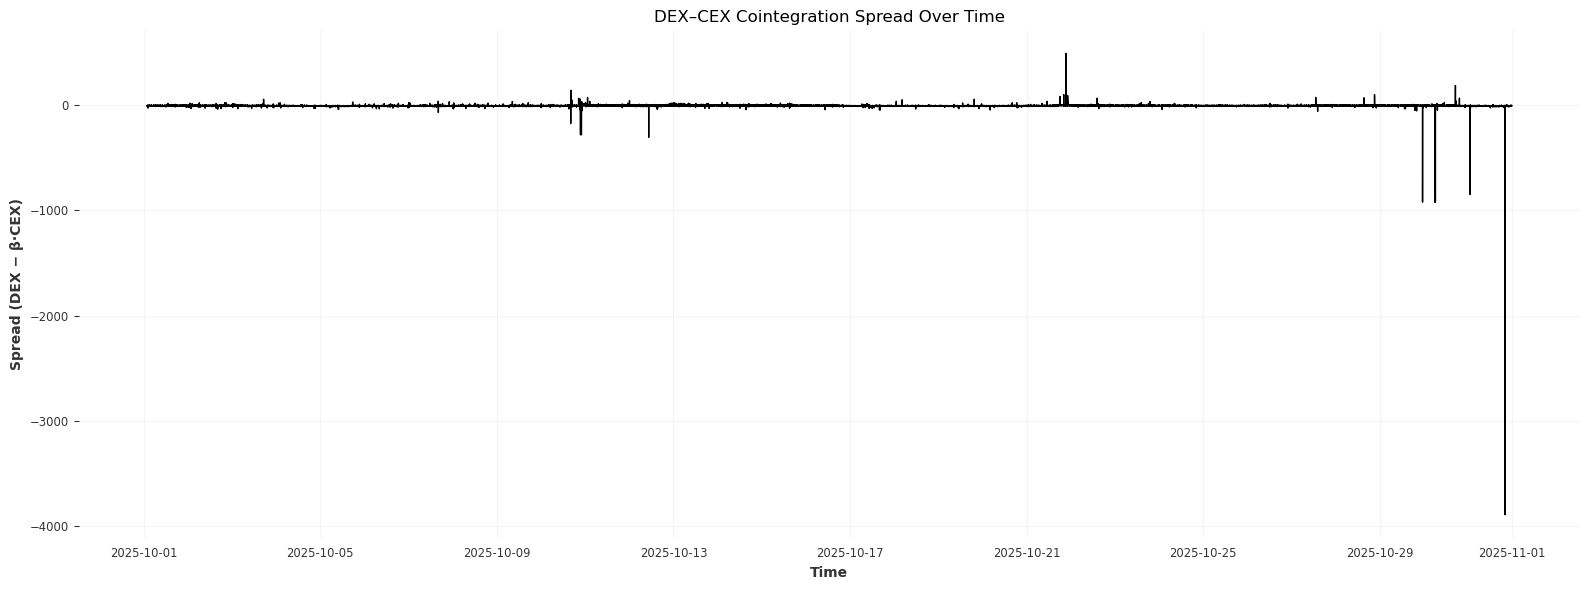

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(df_spread.index, df_spread['spread'], linewidth=1)
plt.title('DEX–CEX Cointegration Spread Over Time')
plt.xlabel('Time')
plt.ylabel('Spread (DEX − β·CEX)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


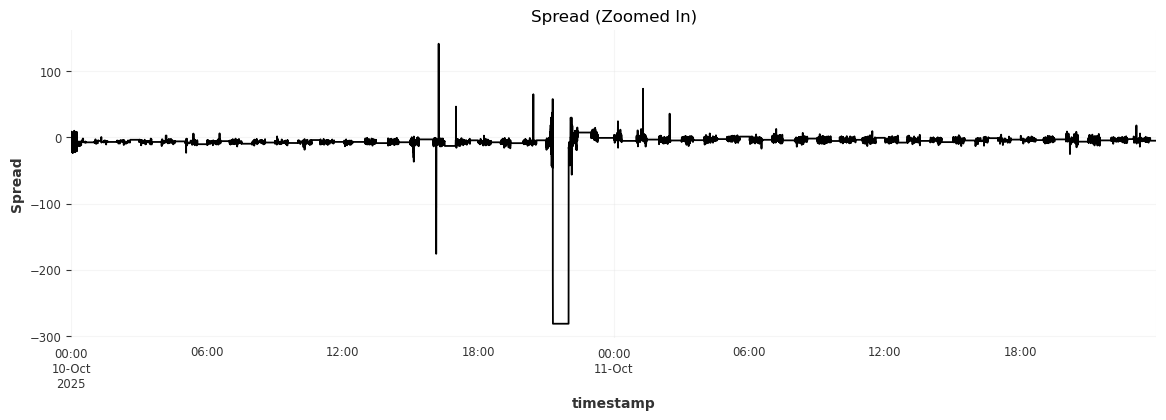

In [36]:
df_spread.loc['2025-10-10':'2025-10-11', 'spread'].plot(figsize=(14,4))
plt.title('Spread (Zoomed In)')
plt.ylabel('Spread')
plt.grid(True, alpha=0.3)
plt.show()


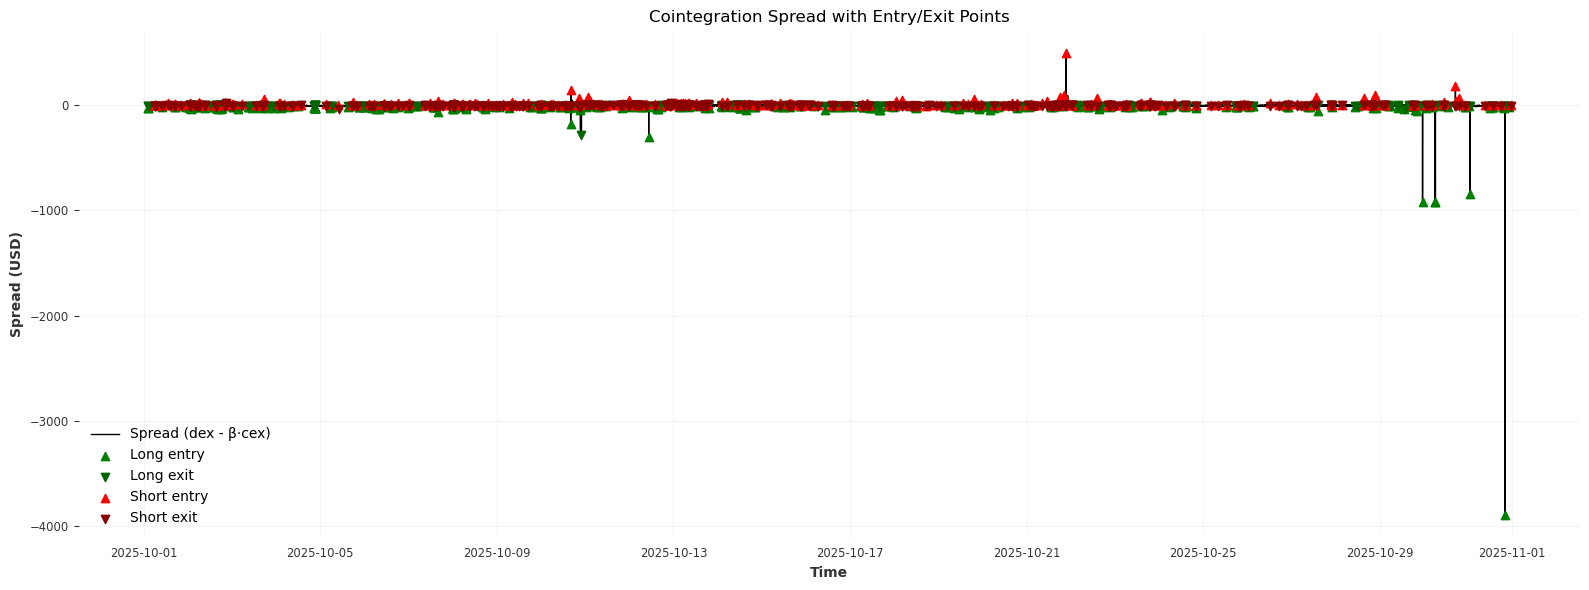

In [37]:
df_spread.index = pd.to_datetime(df_spread.index)
trades_df['entry_time'] = pd.to_datetime(trades_df['entry_time'])
trades_df['exit_time']  = pd.to_datetime(trades_df['exit_time'])

long_trades  = trades_df[trades_df['side'] ==  1]
short_trades = trades_df[trades_df['side'] == -1]

plt.figure(figsize=(16, 6))

# Spread over time
plt.plot(df_spread.index, df_spread['spread'], label='Spread (dex - β·cex)', linewidth=1)

# Long trades: enter when spread is low, exit when it reverts up
plt.scatter(long_trades['entry_time'], long_trades['entry_spread'],
            marker='^', color='green',  label='Long entry',  zorder=5)
plt.scatter(long_trades['exit_time'],  long_trades['exit_spread'],
            marker='v', color='darkgreen', label='Long exit', zorder=5)

# Short trades: enter when spread is high, exit when it reverts down
plt.scatter(short_trades['entry_time'], short_trades['entry_spread'],
            marker='^', color='red',   label='Short entry', zorder=5)
plt.scatter(short_trades['exit_time'],  short_trades['exit_spread'],
            marker='v', color='darkred', label='Short exit', zorder=5)

plt.title('Cointegration Spread with Entry/Exit Points')
plt.xlabel('Time')
plt.ylabel('Spread (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


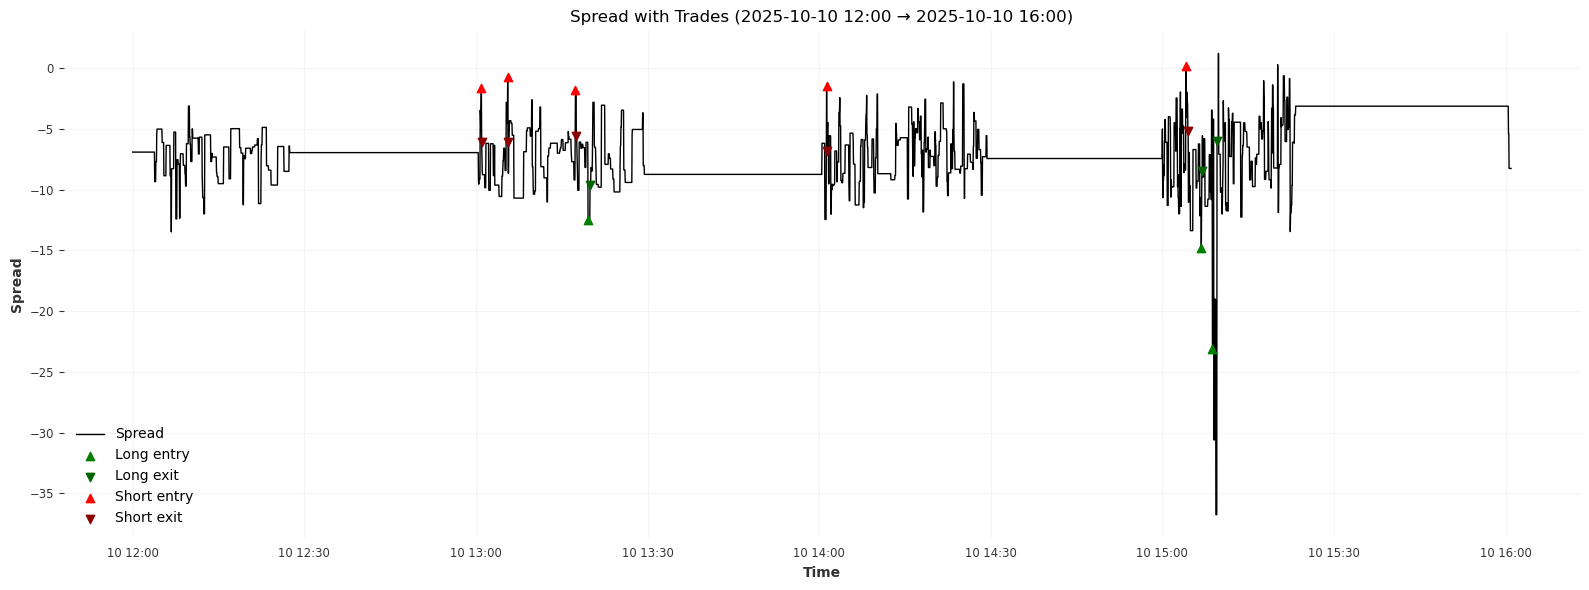

In [38]:
start = '2025-10-10 12:00'
end   = '2025-10-10 16:00'

df_zoom = df_spread.loc[start:end]
long_zoom  = long_trades[(long_trades['entry_time'] >= start) & (long_trades['entry_time'] <= end)]
short_zoom = short_trades[(short_trades['entry_time'] >= start) & (short_trades['entry_time'] <= end)]

plt.figure(figsize=(16, 6))

plt.plot(df_zoom.index, df_zoom['spread'], linewidth=1, label='Spread')

plt.scatter(long_zoom['entry_time'],  long_zoom['entry_spread'],
            marker='^', color='green', label='Long entry', zorder=5)
plt.scatter(long_zoom['exit_time'],   long_zoom['exit_spread'],
            marker='v', color='darkgreen', label='Long exit', zorder=5)

plt.scatter(short_zoom['entry_time'], short_zoom['entry_spread'],
            marker='^', color='red', label='Short entry', zorder=5)
plt.scatter(short_zoom['exit_time'],  short_zoom['exit_spread'],
            marker='v', color='darkred', label='Short exit', zorder=5)

plt.title(f'Spread with Trades ({start} → {end})')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


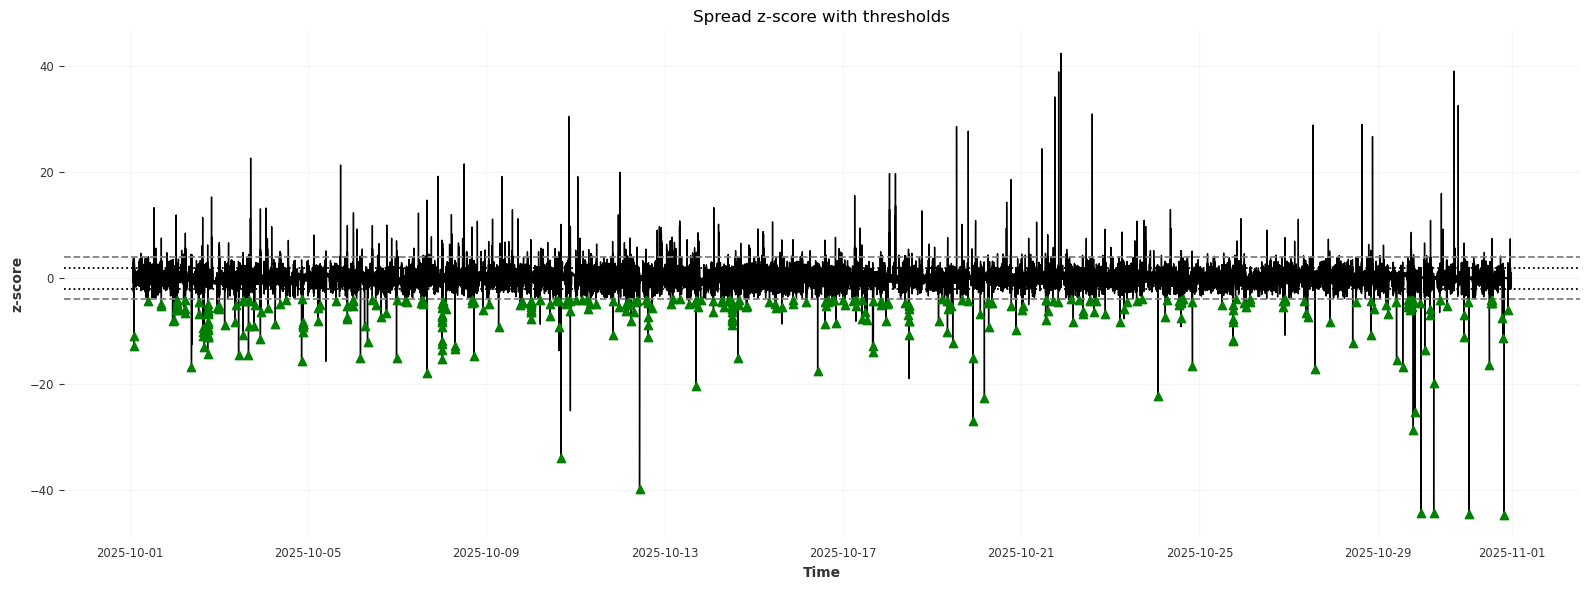

In [39]:
plt.figure(figsize=(16, 6))
plt.plot(df_spread.index, df_spread['spread_z'], label='Spread z-score', linewidth=1)
plt.axhline(z_entry,  color='grey', linestyle='--', label='Entry threshold')
plt.axhline(-z_entry, color='grey', linestyle='--')
plt.axhline(z_exit,   color='black', linestyle=':', label='Exit band')
plt.axhline(-z_exit,  color='black', linestyle=':')

plt.scatter(long_trades['entry_time'],  (long_trades['entry_spread']  - df_spread['spread_mean'].reindex(long_trades['entry_time']).values) /
                                      df_spread['spread_std'].reindex(long_trades['entry_time']).values,
            marker='^', color='green', zorder=5)

# you can do the same mapping for exits / short trades if you want

plt.title('Spread z-score with thresholds')
plt.xlabel('Time')
plt.ylabel('z-score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [40]:
if len(trades_df) > 0:
    total_net_pnl = trades_df['net_pnl'].sum()
    total_gross_pnl = trades_df['gross_pnl'].sum()
    avg_net_pnl = trades_df['net_pnl'].mean()
    hit_rate = (trades_df['net_pnl'] > 0).mean()
    median_holding = trades_df['holding_sec'].median()

    print(f"Total gross PnL: {total_gross_pnl:.2f} USD")
    print(f"Total net PnL  : {total_net_pnl:.2f} USD (after costs)")
    print(f"Avg net PnL/trade: {avg_net_pnl:.4f} USD")
    print(f"Hit rate: {hit_rate*100:.1f}%")
    print(f"Median holding time: {median_holding:.1f} seconds")

    # Very rough annualized Sharpe-style stat (ignore compounding)
    # assume 1 'day' = full sample / (N seconds) but for now:
    pnl_series = trades_df['net_pnl']
    if pnl_series.std() > 0:
        sharpe_like = pnl_series.mean() / pnl_series.std() * np.sqrt(len(pnl_series))
        print(f"Simple Sharpe-like: {sharpe_like:.2f}")
else:
    print("No trades triggered with these parameters.")


Total gross PnL: 20173.13 USD
Total net PnL  : 13210.54 USD (after costs)
Avg net PnL/trade: 15.7081 USD
Hit rate: 63.1%
Median holding time: 9.0 seconds
Simple Sharpe-like: 3.06


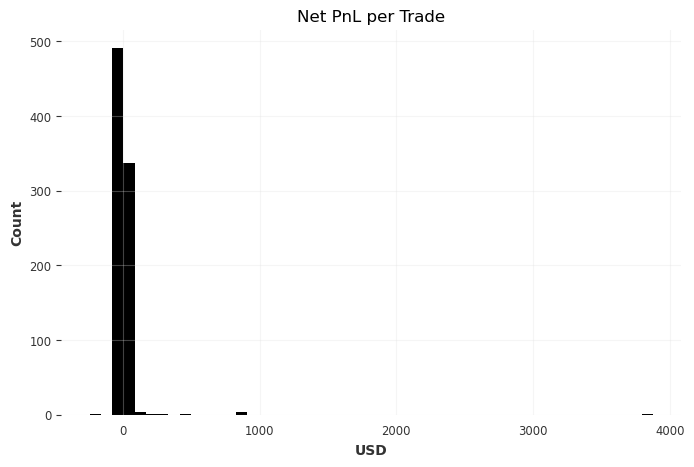

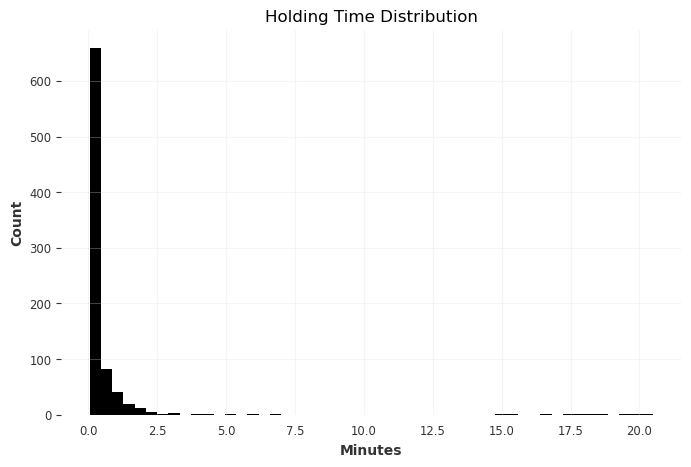

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
trades_df['net_pnl'].hist(bins=50)
plt.title('Net PnL per Trade')
plt.xlabel('USD')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8,5))
(trades_df['holding_sec'] / 60).hist(bins=50)
plt.title('Holding Time Distribution')
plt.xlabel('Minutes')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()


In [52]:
df_filled.index = df_filled.index.tz_localize('UTC')
df_filled

TypeError: Already tz-aware, use tz_convert to convert.

In [53]:
gas_df = pd.read_csv("eth_blocks_2025_10.csv", parse_dates=["timestamp"])
gas_df.set_index("timestamp", inplace=True)
gas_df

,block,base_fee_gwei,gas_used_ratio
timestamp,,,
2025-10-01 00:00:11+00:00,23479244,0.170842,0.828981
2025-10-01 00:00:23+00:00,23479245,0.184893,0.681497
2025-10-01 00:00:35+00:00,23479246,0.193282,0.459371
2025-10-01 00:00:47+00:00,23479247,0.191319,0.460847
2025-10-01 00:00:59+00:00,23479248,0.189446,0.550238
...,...,...,...
2025-10-30 23:59:11+00:00,23693624,0.107225,0.523330
2025-10-30 23:59:23+00:00,23693625,0.107851,0.366043
2025-10-30 23:59:35+00:00,23693626,0.104239,0.519415


In [55]:
gas_3s = gas_df.resample("3S").ffill()
df_with_gas = df_filled.join(gas_3s, how="left").ffill()
df_with_gas.dropna(inplace=True)
df_with_gas.head(20)

/var/folders/5w/tld6r38s2xg4_3yjmhmggv980000gn/T/ipykernel_22371/2008452889.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  gas_3s = gas_df.resample("3S").ffill()


,dex_price,cex_price,block,base_fee_gwei,gas_used_ratio
timestamp,,,,,
2025-10-01 00:00:12+00:00,4148.289107,4146.678950,23479244.0,0.170842,0.828981
2025-10-01 00:00:15+00:00,4149.004069,4147.120565,23479244.0,0.170842,0.828981
2025-10-01 00:00:18+00:00,4150.025145,4146.967599,23479244.0,0.170842,0.828981
2025-10-01 00:00:21+00:00,4149.712129,4146.757055,23479244.0,0.170842,0.828981
2025-10-01 00:00:24+00:00,4146.727186,4146.727621,23479245.0,0.184893,0.681497
2025-10-01 00:00:27+00:00,4150.688672,4146.775334,23479245.0,0.184893,0.681497
2025-10-01 00:00:30+00:00,4147.045236,4147.384558,23479245.0,0.184893,0.681497
2025-10-01 00:00:33+00:00,4146.965943,4147.362247,23479245.0,0.184893,0.681497
2025-10-01 00:00:36+00:00,4149.163149,4146.964771,23479246.0,0.193282,0.459371


In [59]:
# 1. Estimate beta from dex ~ cex
y = df_with_gas['dex_price']
X = sm.add_constant(df_with_gas['cex_price'])
res = sm.OLS(y, X).fit()
beta = res.params['cex_price']
print("Estimated beta:", beta)

# 2. Construct spread
df_with_gas['spread'] = df_with_gas['dex_price'] - beta * df_with_gas['cex_price']

# 3. Rolling mean/std and z-score
window = 2000  # ~ 2000 * 3s ≈ 100 minutes, tune if you like

df_with_gas['spread_mean'] = df_with_gas['spread'].rolling(window).mean()
df_with_gas['spread_std']  = df_with_gas['spread'].rolling(window).std()

df_with_gas['spread_z'] = (df_with_gas['spread'] - df_with_gas['spread_mean']) / df_with_gas['spread_std']
df_with_gas = df_with_gas.dropna(subset=['spread_z'])

Estimated beta: 1.002150346760844


In [60]:
df_with_gas

,dex_price,cex_price,block,base_fee_gwei,gas_used_ratio,spread,spread_mean,spread_std,spread_z
timestamp,,,,,,,,,
2025-10-01 01:40:09+00:00,4154.308372,4153.599851,23479740.0,0.124490,0.721452,-8.223160,-7.485075,1.470081,-0.502071
2025-10-01 01:40:12+00:00,4154.308372,4153.599851,23479741.0,0.131382,0.357164,-8.223160,-7.485533,1.470169,-0.501729
2025-10-01 01:40:15+00:00,4154.308372,4153.599851,23479741.0,0.131382,0.357164,-8.223160,-7.486128,1.470226,-0.501305
2025-10-01 01:40:18+00:00,4154.308372,4153.599851,23479741.0,0.131382,0.357164,-8.223160,-7.487309,1.469868,-0.500623
2025-10-01 01:40:21+00:00,4154.308372,4153.599851,23479741.0,0.131382,0.357164,-8.223160,-7.488440,1.469564,-0.499958
...,...,...,...,...,...,...,...,...,...
2025-10-31 23:45:27+00:00,3858.445123,3858.569559,23693627.0,0.104745,0.415229,-8.421699,-8.248364,1.539212,-0.112613
2025-10-31 23:45:30+00:00,3858.445123,3858.569559,23693627.0,0.104745,0.415229,-8.421699,-8.247963,1.539063,-0.112884
2025-10-31 23:45:33+00:00,3858.445123,3858.569559,23693627.0,0.104745,0.415229,-8.421699,-8.247563,1.538913,-0.113155


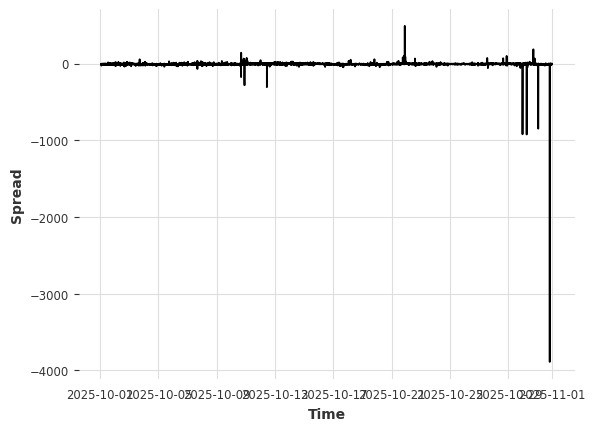

In [86]:
plt.plot(df_with_gas.index, df_with_gas['spread'])
plt.xlabel("Time")
plt.ylabel("Spread")
plt.show()

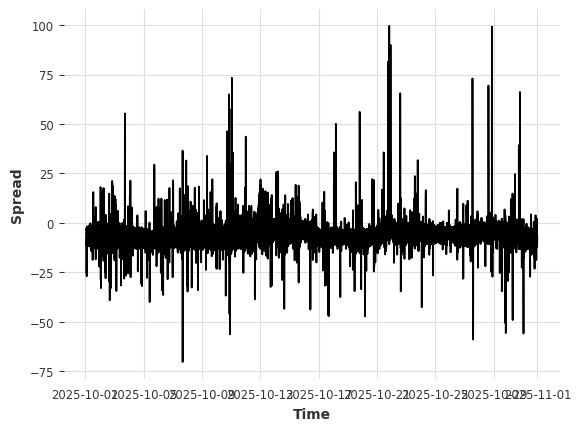

In [87]:
filtered = df_with_gas[(df_with_gas['spread'] >= -100) & (df_with_gas['spread'] <= 100)]

plt.plot(filtered.index, filtered['spread'])
plt.xlabel("Time")
plt.ylabel("Spread")
plt.show()


In [75]:
# Bin by base fee (you could also try gas_used_ratio instead)
n_q = 20
df_with_gas['gas_bin'] = pd.qcut(df_with_gas['base_fee_gwei'], q=n_q, labels=False)

def pct_large_z(x, thresh=2.0):
    return (np.abs(x) > thresh).mean()

grouped = df_with_gas.groupby('gas_bin').agg(
    avg_gas=('base_fee_gwei', 'mean'),
    avg_abs_spread=('spread', lambda x: np.mean(np.abs(x))),
    avg_abs_z=('spread_z', lambda x: np.mean(np.abs(x))),
    pct_large_misprice=('spread_z', pct_large_z),
    count=('spread', 'size')
).reset_index()

grouped

,gas_bin,avg_gas,avg_abs_spread,avg_abs_z,pct_large_misprice,count
0,0,0.082217,5.123539,0.854083,0.057065,44528
1,1,0.094635,5.317427,0.829915,0.052623,44524
2,2,0.103158,7.285166,0.786077,0.060139,68442
3,3,0.105931,6.790992,0.791516,0.055405,20612
4,4,0.109506,6.907316,0.771133,0.055902,44524
5,5,0.114298,7.146349,0.764192,0.050579,44524
6,6,0.119683,7.030026,0.775321,0.052057,44528
7,7,0.126057,6.815562,0.767764,0.051926,44525
8,8,0.133923,6.887654,0.777359,0.057317,44524
9,9,0.145654,6.541198,0.788083,0.055426,44528


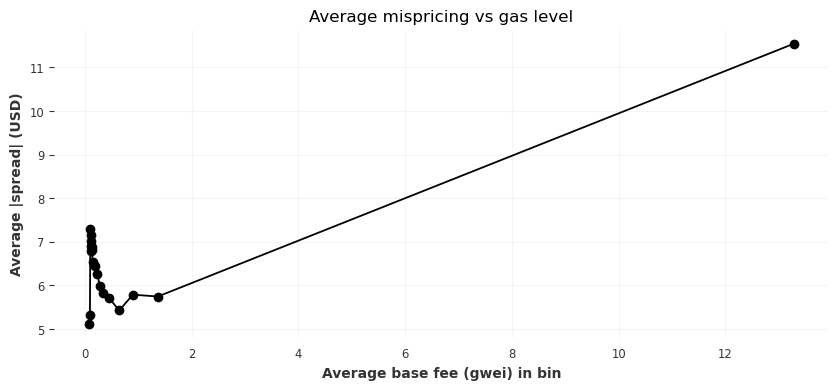

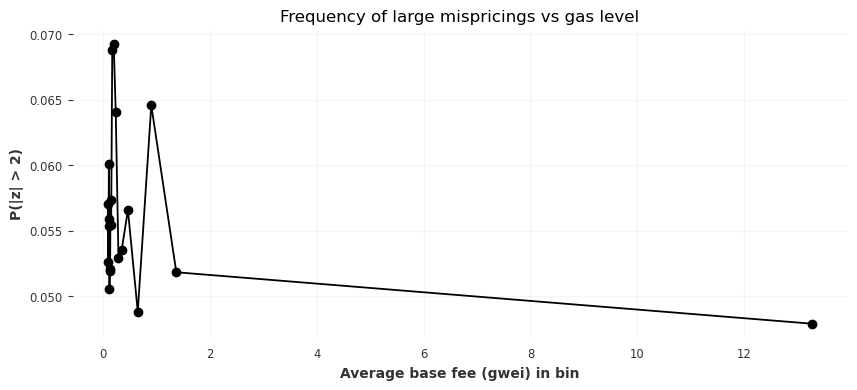

In [76]:
plt.figure(figsize=(10,4))
plt.plot(grouped['avg_gas'], grouped['avg_abs_spread'], marker='o')
plt.xlabel('Average base fee (gwei) in bin')
plt.ylabel('Average |spread| (USD)')
plt.title('Average mispricing vs gas level')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(grouped['avg_gas'], grouped['pct_large_misprice'], marker='o')
plt.xlabel('Average base fee (gwei) in bin')
plt.ylabel('P(|z| > 2)')
plt.title('Frequency of large mispricings vs gas level')
plt.grid(True, alpha=0.3)
plt.show()


For gas below ~1 gwei: The average spread is roughly flat (around 5-7). No strong dependence on gas. The market behaves as “efficient but noisy”. When Ethereum is cheap to use, arbitrage happens normally and keeps prices aligned. At extremely high gas (~13 gwei bin), the average mispricing jumps dramatically.

At low to medium gas, large mispricings happen at a stable rate. At high gas, you can see that there are not more mispricings. It makes the mispricings larger but not more frequent necessarily.


In [90]:
events = []

i = 0
n = len(df_with_gas)

while i < n:
    if np.abs(spread_z[i]) > z_entry:
        entry_idx = i
        entry_time = times[i]
        entry_gas = gas_arr[i]
        entry_spread = df_with_gas['spread'].iloc[i]
        entry_z = spread_z[i]

        j = i + 1
        while j < n and np.abs(spread_z[j]) > z_exit:
            j += 1

        if j < n:
            exit_time = times[j]
            exit_spread = df_with_gas['spread'].iloc[j]

            holding_sec = (exit_time - entry_time) / np.timedelta64(1, 's')

            # Direction
            side = -1 if entry_z > 0 else 1

            # Profit normalized to 1 ETH equivalent notional
            pnl = side * (entry_spread - exit_spread)

            events.append({
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_gas': entry_gas,
                'entry_spread': entry_spread,
                'exit_spread': exit_spread,
                'half_life_sec': holding_sec,
                'side': side,
                'pnl': pnl
            })

        i = j
    else:
        i += 1

events_df = pd.DataFrame(events)
events_df = events_df[events_df['half_life_sec'] > 0]
events_df

,entry_time,exit_time,entry_gas,entry_spread,exit_spread,half_life_sec,side,pnl
0,2025-10-01 02:00:18+00:00,2025-10-01 02:00:21+00:00,0.133526,-4.831449,-8.075376,3.0,-1,-3.243927
1,2025-10-01 02:00:30+00:00,2025-10-01 02:00:33+00:00,0.130519,-4.159310,-7.861618,3.0,-1,-3.702308
2,2025-10-01 02:00:57+00:00,2025-10-01 02:01:03+00:00,0.135944,-4.102447,-7.848047,6.0,-1,-3.745600
3,2025-10-01 02:01:06+00:00,2025-10-01 02:01:12+00:00,0.134809,-4.458731,-8.040357,6.0,-1,-3.581626
4,2025-10-01 02:01:27+00:00,2025-10-01 02:01:54+00:00,0.140355,-3.914648,-7.374661,27.0,-1,-3.460013
...,...,...,...,...,...,...,...,...
4898,2025-10-31 23:01:00+00:00,2025-10-31 23:01:18+00:00,0.104745,-4.609190,-8.445272,18.0,-1,-3.836082
4899,2025-10-31 23:04:36+00:00,2025-10-31 23:04:54+00:00,0.104745,-11.875714,-8.820013,18.0,1,-3.055701
4900,2025-10-31 23:18:45+00:00,2025-10-31 23:18:51+00:00,0.104745,2.071075,-8.995730,6.0,-1,-11.066805
4901,2025-10-31 23:24:00+00:00,2025-10-31 23:30:15+00:00,0.104745,-5.597197,-7.790136,375.0,-1,-2.192939


In [91]:
# Remove crazy-long or 0-length events if any (optional cleaning)
events_df = events_df[events_df['half_life_sec'] > 0]

# Bin by gas at entry
events_df['gas_bin'] = pd.qcut(events_df['entry_gas'], q=20, labels=False)

hl_grouped = events_df.groupby('gas_bin').agg(
    avg_gas=('entry_gas', 'mean'),
    median_half_life=('half_life_sec', 'median'),
    mean_half_life=('half_life_sec', 'mean'),
    count=('half_life_sec', 'size')
).reset_index()

hl_grouped


,gas_bin,avg_gas,median_half_life,mean_half_life,count
0,0,0.088585,49.5,182.048780,246
1,1,0.102891,33.0,115.476923,325
2,2,0.107284,24.0,108.272727,165
3,3,0.113318,30.0,152.902041,245
4,4,0.120266,24.0,116.069388,245
5,5,0.127685,27.0,109.359184,245
6,6,0.137054,24.0,68.289796,245
7,7,0.149347,21.0,65.865306,245
8,8,0.172006,27.0,120.293878,245
9,9,0.202592,33.0,98.170732,246


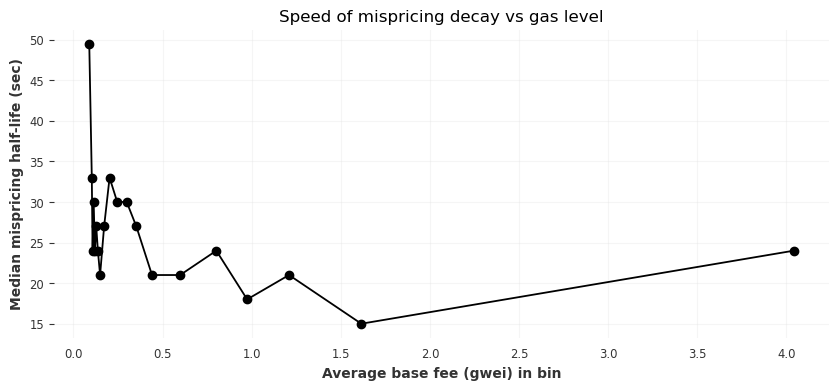

In [92]:
plt.figure(figsize=(10,4))
plt.plot(hl_grouped['avg_gas'], hl_grouped['median_half_life'], marker='o')
plt.xlabel('Average base fee (gwei) in bin')
plt.ylabel('Median mispricing half-life (sec)')
plt.title('Speed of mispricing decay vs gas level')
plt.grid(True, alpha=0.3)
plt.show()


At almost 0 gas you can see there is a very high half-life of around 50 seconds. This is unintuitive. At low gas the arbitrage here become cheap obviously but the half life the mispricing is actually the highest when gas is at its lowest.

At moderate gas level you see around the fastest mispricing convergence.

At high gas level, half-life is a bit higher than at a moderate gas level.

When gas is in the 95th percentile, how long does it remain there?

95th percentile gas threshold: 1.841716974


/var/folders/5w/tld6r38s2xg4_3yjmhmggv980000gn/T/ipykernel_22371/2866766710.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stress_durations = stress_segments.apply(


,stress_block,duration_sec
count,213.000000,213.00000
mean,214.000000,624.15493
std,123.263944,2189.00390
min,2.000000,9.00000
25%,108.000000,9.00000
50%,214.000000,33.00000
75%,320.000000,201.00000
max,426.000000,23889.00000


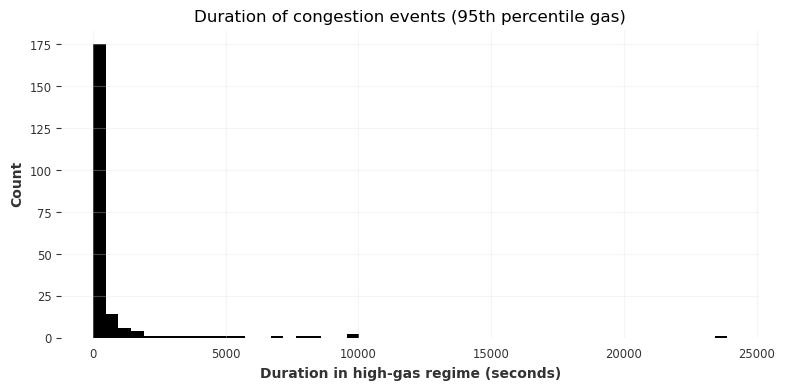

In [202]:
# High-gas threshold
gas_95 = df_with_gas['base_fee_gwei'].quantile(0.95)
print("95th percentile gas threshold:", gas_95)

# Binary stress indicator
df_with_gas['high_gas'] = df_with_gas['base_fee_gwei'] >= gas_95

# Assign an ID to each continuous run of True/False
df_with_gas['stress_block'] = (df_with_gas['high_gas'] != df_with_gas['high_gas'].shift()).cumsum()

# Keep only high-gas segments
stress_segments = df_with_gas[df_with_gas['high_gas']].groupby('stress_block')

stress_durations = stress_segments.apply(
    lambda x: (x.index[-1] - x.index[0]).total_seconds()
).reset_index(name='duration_sec')

# Remove tiny blips (e.g. < 2 blocks)
stress_durations = stress_durations[stress_durations['duration_sec'] > 5]

display(stress_durations.describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
plt.hist(stress_durations['duration_sec'], bins=50)
plt.xlabel("Duration in high-gas regime (seconds)")
plt.ylabel("Count")
plt.title("Duration of congestion events (95th percentile gas)")
plt.grid(True, alpha=0.3)
plt.show()

Median is about 33 seconds

In [ ]:
import numpy as np
import pandas as pd

# --- Assumes df_with_gas already has these columns ---
# ['dex_price', 'cex_price', 'base_fee_gwei', 'spread', 'spread_z']

# 1) Define gas and z thresholds
gas_hi   = df_with_gas['base_fee_gwei'].quantile(0.95)   # "stress" regime
gas_med  = df_with_gas['base_fee_gwei'].median()         # "normal" regime

z_entry  = 2.0   # enter when |z| >= z_entry AND gas is high
z_exit   = 0.5   # exit when |z| <= z_exit  OR gas back to normal
max_hold_sec = 15000   # cap on holding time in seconds, CUTOFF SOME OF THE OUTLIERS

print(f"High-gas threshold (95%): {gas_hi:.4f} gwei")
print(f"Median gas: {gas_med:.4f} gwei")

# 2) Pull numpy arrays for speed
spread    = df_with_gas['spread'].values
spread_z  = df_with_gas['spread_z'].values
gas       = df_with_gas['base_fee_gwei'].values
times     = df_with_gas.index.to_numpy()

n = len(df_with_gas)
events = []

i = 0
while i < n:
    # ENTRY condition: big mispricing + high gas
    if (gas[i] >= gas_hi) and (np.abs(spread_z[i]) >= z_entry):
        entry_idx    = i
        entry_time   = times[i]
        entry_spread = spread[i]
        entry_gas    = gas[i]
        entry_z      = spread_z[i]

        # DEX rich => short spread, DEX cheap => long spread
        side = -1 if entry_z > 0 else 1

        # Search forward for exit
        j = i + 1
        exit_reason = None
        while j < n:
            dt_sec = (times[j] - entry_time) / np.timedelta64(1, 's')

            # condition 1: spread reverted
            if np.abs(spread_z[j]) <= z_exit:
                exit_reason = 'spread_revert'
                break

            # condition 2: gas normalized back below median
            if gas[j] <= gas_med:
                exit_reason = 'gas_normal'
                break

            # condition 3: max holding time reached
            if dt_sec >= max_hold_sec:
                exit_reason = 'time_limit'
                break

            j += 1

        # If we found an exit point
        if j < n and exit_reason is not None:
            exit_time   = times[j]
            exit_spread = spread[j]
            exit_gas    = gas[j]
            exit_z      = spread_z[j]
            holding_sec = (exit_time - entry_time) / np.timedelta64(1, 's')

            pnl = side * (exit_spread - entry_spread)

            events.append({
                'entry_idx': entry_idx,
                'exit_idx': j,
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_gas': entry_gas,
                'exit_gas': exit_gas,
                'entry_z': entry_z,
                'exit_z': exit_z,
                'entry_spread': entry_spread,
                'exit_spread': exit_spread,
                'side': side,
                'holding_sec': holding_sec,
                'pnl': pnl,
                'exit_reason': exit_reason,
            })

            # jump to after exit to avoid overlapping trades
            i = j + 1
        else:
            # ran out of data
            break
    else:
        i += 1

# 3) Wrap into DataFrame
stress_events_df = pd.DataFrame(events)
print(f"Number of high-gas trades: {len(stress_events_df)}")

# ----------------------------
# ADD GAS COSTS ONLY
# ----------------------------

# Assumptions for gas:
gas_used_per_tx = 200_000          # gas units per DEX trade (tune this)
n_onchain_txs   = 2                # 1 tx at entry, 1 at exit
notional_eth    = 1.0              # 1 ETH notional equivalent for spread

# Get ETH prices (use CEX as ETH/USD proxy)
dex_prices = df_with_gas['dex_price'].values
cex_prices = df_with_gas['cex_price'].values

stress_events_df['entry_cex_price'] = cex_prices[stress_events_df['entry_idx'].values]
stress_events_df['exit_cex_price']  = cex_prices[stress_events_df['exit_idx'].values]

# Gas cost (USD) = base_fee_gwei * 1e-9 ETH/gas * gas_used_per_tx * ETH_price * n_onchain_txs_side
# Here we assume 1 swap at entry + 1 swap at exit, both on-chain.
stress_events_df['gas_cost_entry_usd'] = (
    stress_events_df['entry_gas'] * 1e-9 * gas_used_per_tx * stress_events_df['entry_cex_price']
)
stress_events_df['gas_cost_exit_usd'] = (
    stress_events_df['exit_gas'] * 1e-9 * gas_used_per_tx * stress_events_df['exit_cex_price']
)

stress_events_df['gas_cost_usd'] = (
    stress_events_df['gas_cost_entry_usd'] +
    stress_events_df['gas_cost_exit_usd']
)

# Net PnL after gas only
stress_events_df['gross_pnl'] = stress_events_df['pnl']
stress_events_df['net_pnl']   = stress_events_df['gross_pnl'] - stress_events_df['gas_cost_usd']

# Quick sanity check
print("Mean gross PnL:", stress_events_df['gross_pnl'].mean())
print("Mean gas cost (USD):", stress_events_df['gas_cost_usd'].mean())
print("Mean net PnL:", stress_events_df['net_pnl'].mean())
print("Net win rate:", (stress_events_df['net_pnl'] > 0).mean())

stress_events_df.head()


High-gas threshold (95%): 1.8417 gwei
Median gas: 0.1545 gwei
Number of high-gas trades: 286
Mean gross PnL: 9.419265487965996
Mean gas cost (USD): 6.505197385620867
Mean net PnL: 2.9140681023451305
Net win rate: 0.6818181818181818


,entry_idx,exit_idx,entry_time,exit_time,entry_gas,exit_gas,entry_z,exit_z,entry_spread,exit_spread,...,holding_sec,pnl,exit_reason,entry_cex_price,exit_cex_price,gas_cost_entry_usd,gas_cost_exit_usd,gas_cost_usd,gross_pnl,net_pnl
0,14984,14987,2025-10-01 14:09:21+00:00,2025-10-01 14:09:30+00:00,1.890893,1.935180,-2.544651,0.168827,-10.721441,-6.073039,...,9.0,4.648402,spread_revert,4301.576036,4302.798492,1.626764,1.665338,3.292101,4.648402,1.356300
1,15021,15022,2025-10-01 14:11:12+00:00,2025-10-01 14:11:15+00:00,1.879478,1.879478,-2.134147,-0.487714,-10.078662,-7.217954,...,3.0,2.860708,spread_revert,4310.221475,4309.957584,1.620193,1.620094,3.240288,2.860708,-0.379579
2,15068,15069,2025-10-01 14:13:33+00:00,2025-10-01 14:13:36+00:00,1.849804,1.847072,2.583763,0.218348,-1.792879,-5.963198,...,3.0,4.170318,spread_revert,4302.809653,4303.296977,1.591871,1.589700,3.181570,4.170318,0.988748
3,15082,15083,2025-10-01 14:14:15+00:00,2025-10-01 14:14:18+00:00,1.889458,1.889458,-2.230311,-0.128048,-10.285683,-6.568399,...,3.0,3.717284,spread_revert,4307.517839,4307.425191,1.627775,1.627740,3.255515,3.717284,0.461769
4,15131,15136,2025-10-01 14:16:42+00:00,2025-10-01 14:16:57+00:00,1.911064,1.952648,2.552993,-0.260119,-1.762559,-6.800233,...,15.0,5.037674,spread_revert,4301.551672,4305.438865,1.644108,1.681401,3.325509,5.037674,1.712164


ALL IN NET_PNL

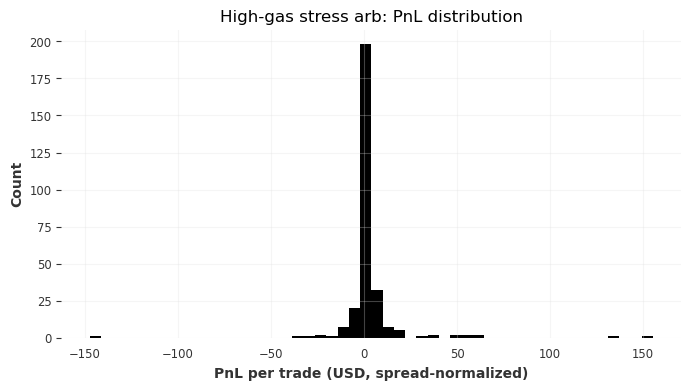

In [222]:
plt.figure(figsize=(8,4))
stress_events_df['net_pnl'].hist(bins=50)
plt.xlabel('PnL per trade (USD, spread-normalized)')
plt.ylabel('Count')
plt.title('High-gas stress arb: PnL distribution')
plt.grid(True, alpha=0.3)
plt.show()


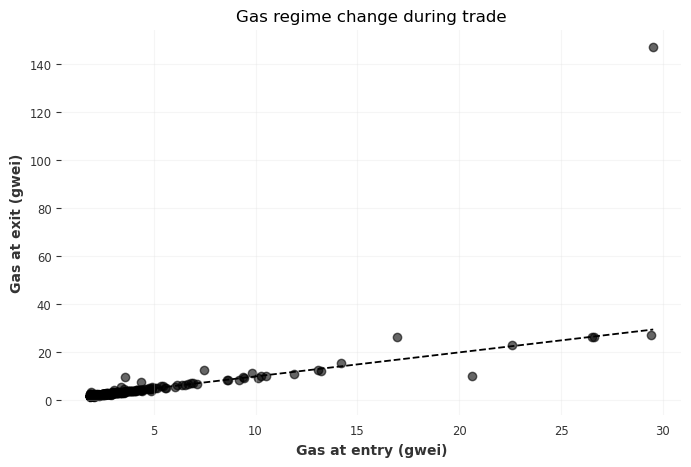

In [215]:
plt.figure(figsize=(8,5))
plt.scatter(stress_events_df['entry_gas'], stress_events_df['exit_gas'], alpha=0.6)
plt.plot([stress_events_df['entry_gas'].min(), stress_events_df['entry_gas'].max()],
         [stress_events_df['entry_gas'].min(), stress_events_df['entry_gas'].max()],
         linestyle='--')

plt.xlabel("Gas at entry (gwei)")
plt.ylabel("Gas at exit (gwei)")
plt.title("Gas regime change during trade")
plt.grid(True, alpha=0.3)
plt.show()

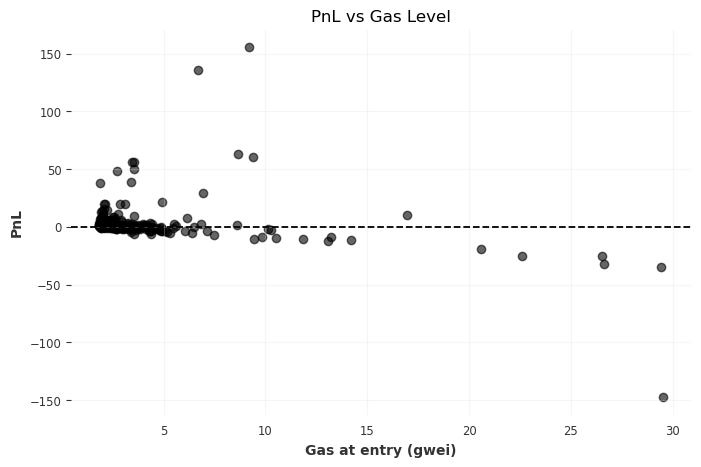

In [216]:
plt.figure(figsize=(8,5))
plt.scatter(stress_events_df['entry_gas'], stress_events_df['net_pnl'], alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Gas at entry (gwei)")
plt.ylabel("PnL")
plt.title("PnL vs Gas Level")
plt.grid(True, alpha=0.3)
plt.show()


That doesn't look good.

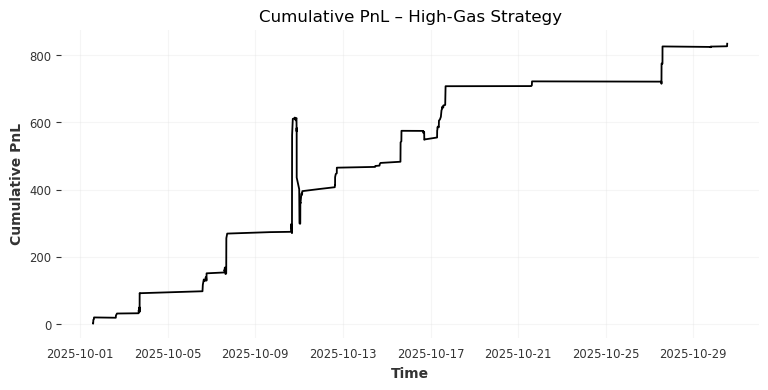

In [217]:
stress_events_df = stress_events_df.sort_values("entry_time")
stress_events_df['cum_pnl'] = stress_events_df['net_pnl'].cumsum()

plt.figure(figsize=(9,4))
plt.plot(stress_events_df['entry_time'], stress_events_df['cum_pnl'])
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.title("Cumulative PnL – High-Gas Strategy")
plt.grid(True, alpha=0.3)
plt.show()


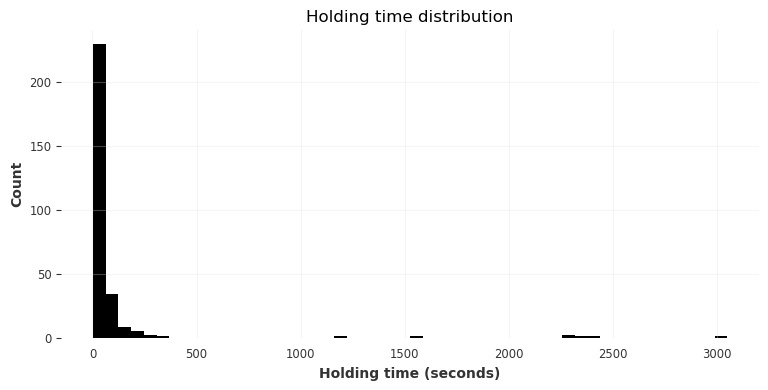

In [218]:
plt.figure(figsize=(9,4))
stress_events_df['holding_sec'].hist(bins=50)
plt.xlabel("Holding time (seconds)")
plt.ylabel("Count")
plt.title("Holding time distribution")
plt.grid(True, alpha=0.3)
plt.show()


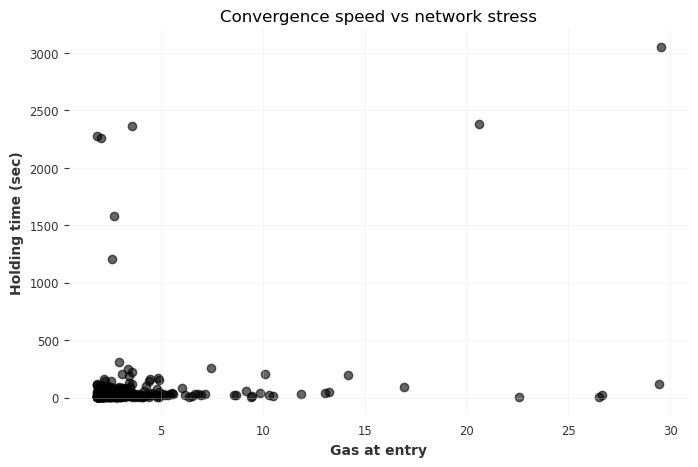

In [219]:
plt.figure(figsize=(8,5))
plt.scatter(stress_events_df['entry_gas'], stress_events_df['holding_sec'], alpha=0.6)
plt.xlabel("Gas at entry")
plt.ylabel("Holding time (sec)")
plt.title("Convergence speed vs network stress")
plt.grid(True, alpha=0.3)
plt.show()


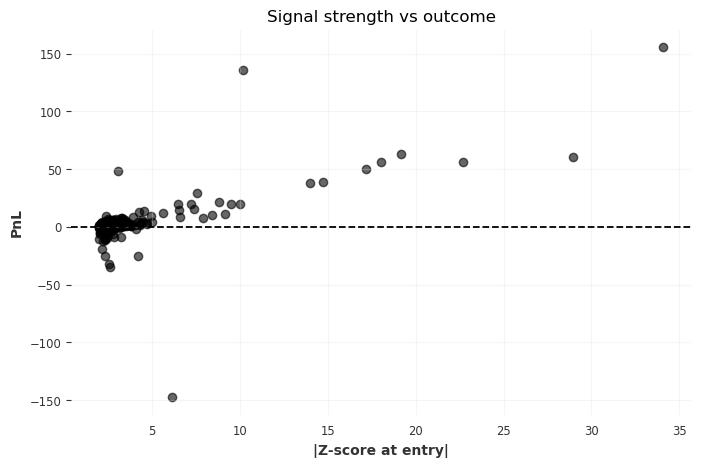

In [220]:
plt.figure(figsize=(8,5))
plt.scatter(np.abs(stress_events_df['entry_z']), stress_events_df['net_pnl'], alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("|Z-score at entry|")
plt.ylabel("PnL")
plt.title("Signal strength vs outcome")
plt.grid(True, alpha=0.3)
plt.show()


Look for optimal Z-score. Looks like Z-score threshold is dominating the signal here. Can also size positions with fractional Kelly based on the Z-score given pnl does prove to be increasing as a function of Z-score.

Probably want to test if conditioning on gas actually does improve the pnl here vs. a strictly Z-score conditioned strategy.

Right now we are just considering gas fees as a cost in trading this.

E[PnL per second | gas_bin]


In [98]:
# Correct the PnL definition
events_df['pnl'] = events_df['side'] * (events_df['exit_spread'] - events_df['entry_spread'])

# Profit per second
events_df['pnl_per_sec'] = events_df['pnl'] / events_df['half_life_sec']

# Re-bin by gas
events_df['gas_bin'] = pd.qcut(events_df['entry_gas'], q=20, labels=False)

profit_by_gas = events_df.groupby('gas_bin').agg(
    avg_gas=('entry_gas', 'mean'),
    avg_pnl=('pnl', 'mean'),
    median_pnl=('pnl', 'median'),
    avg_pnl_per_sec=('pnl_per_sec', 'mean'),
    winrate=('pnl', lambda x: (x > 0).mean()),
    count=('pnl', 'size')
).reset_index()

profit_by_gas


,gas_bin,avg_gas,avg_pnl,median_pnl,avg_pnl_per_sec,winrate,count
0,0,0.088585,4.512320,3.794664,0.383083,1.000000,246
1,1,0.102891,18.992572,3.825038,2.570212,1.000000,325
2,2,0.107284,5.038654,3.847384,0.394207,1.000000,165
3,3,0.113318,9.124397,4.019822,0.421926,1.000000,245
4,4,0.120266,5.964473,4.271792,0.511257,1.000000,245
5,5,0.127685,10.226773,4.335089,0.646599,1.000000,245
6,6,0.137054,9.005470,4.160110,0.749450,1.000000,245
7,7,0.149347,5.065064,4.000208,0.464685,1.000000,245
8,8,0.172006,7.053593,4.295868,0.400318,1.000000,245
9,9,0.202592,6.232237,4.429761,0.464135,1.000000,246


In [99]:
events_df[['entry_time','entry_gas','entry_spread','exit_spread','side','half_life_sec','pnl']].head(10)


,entry_time,entry_gas,entry_spread,exit_spread,side,half_life_sec,pnl
0,2025-10-01 02:00:18+00:00,0.133526,-4.831449,-8.075376,-1,3.0,3.243927
1,2025-10-01 02:00:30+00:00,0.130519,-4.159310,-7.861618,-1,3.0,3.702308
2,2025-10-01 02:00:57+00:00,0.135944,-4.102447,-7.848047,-1,6.0,3.745600
3,2025-10-01 02:01:06+00:00,0.134809,-4.458731,-8.040357,-1,6.0,3.581626
4,2025-10-01 02:01:27+00:00,0.140355,-3.914648,-7.374661,-1,27.0,3.460013
5,2025-10-01 02:01:57+00:00,0.152677,-4.774548,-7.583331,-1,3.0,2.808783
6,2025-10-01 02:02:30+00:00,0.153615,-3.218016,-6.973336,-1,30.0,3.755320
7,2025-10-01 02:03:03+00:00,0.157137,-4.096282,-7.222956,-1,9.0,3.126674
8,2025-10-01 02:03:21+00:00,0.152991,-4.907279,-7.450875,-1,18.0,2.543596
9,2025-10-01 02:03:57+00:00,0.143415,-4.282807,-7.672780,-1,3.0,3.389973


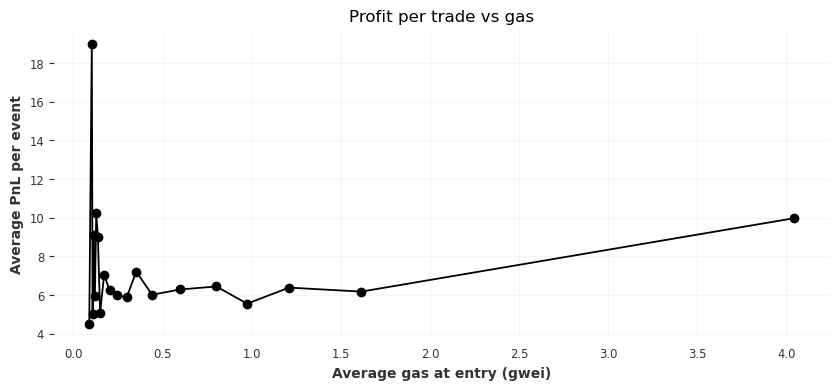

In [100]:
plt.figure(figsize=(10,4))
plt.plot(profit_by_gas['avg_gas'], profit_by_gas['avg_pnl'], marker='o')
plt.xlabel("Average gas at entry (gwei)")
plt.ylabel("Average PnL per event")
plt.title("Profit per trade vs gas")
plt.grid(True, alpha=0.3)
plt.show()


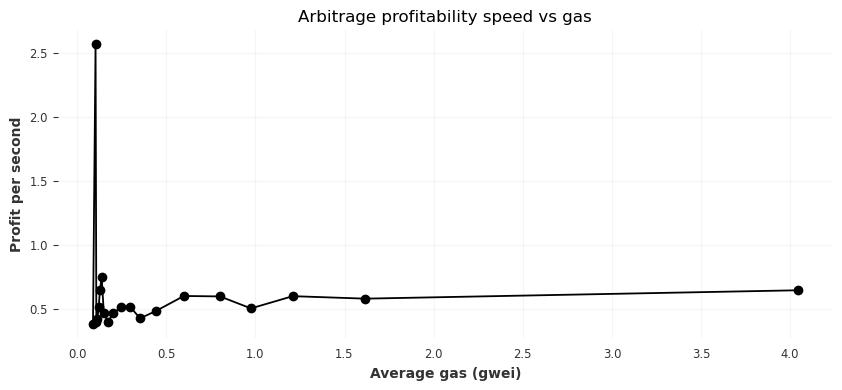

In [101]:
plt.figure(figsize=(10,4))
plt.plot(profit_by_gas['avg_gas'], profit_by_gas['avg_pnl_per_sec'], marker='o')
plt.xlabel("Average gas (gwei)")
plt.ylabel("Profit per second")
plt.title("Arbitrage profitability speed vs gas")
plt.grid(True, alpha=0.3)
plt.show()


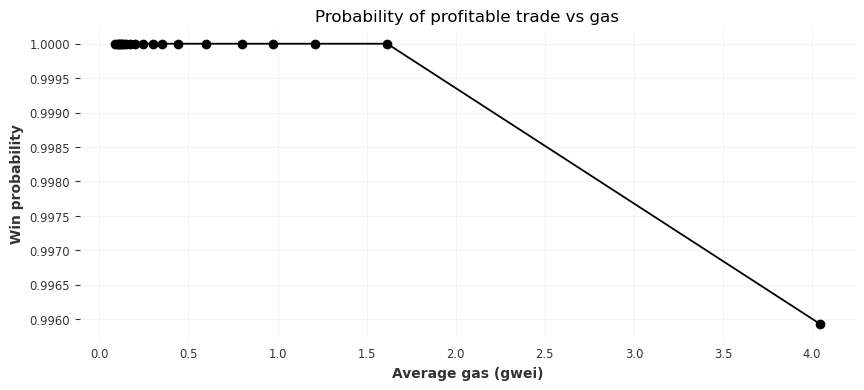

In [102]:
plt.figure(figsize=(10,4))
plt.plot(profit_by_gas['avg_gas'], profit_by_gas['winrate'], marker='o')
plt.xlabel("Average gas (gwei)")
plt.ylabel("Win probability")
plt.title("Probability of profitable trade vs gas")
plt.grid(True, alpha=0.3)
plt.show()


In [103]:
z_entry = 2.0
H_sec   = 15 * 60   # hold 15 minutes, for example

spread_z = df_with_gas['spread_z'].to_numpy()
spread   = df_with_gas['spread'].to_numpy()
gas_arr  = df_with_gas['base_fee_gwei'].to_numpy()
times    = df_with_gas.index.to_numpy()

trades = []
i = 0
n = len(df_with_gas)

while i < n:
    if np.abs(spread_z[i]) > z_entry:
        entry_time   = times[i]
        entry_spread = spread[i]
        entry_gas    = gas_arr[i]
        entry_z      = spread_z[i]
        side         = -1 if entry_z > 0 else 1  # short high, long low

        # target exit time
        target_time = entry_time + np.timedelta64(H_sec, 's')

        # find index closest to target_time but not beyond end
        j = i
        while j < n and times[j] < target_time:
            j += 1

        if j < n:
            exit_time   = times[j]
            exit_spread = spread[j]
            holding_sec = (exit_time - entry_time) / np.timedelta64(1, 's')
            pnl         = side * (exit_spread - entry_spread)

            trades.append({
                'entry_time': entry_time,
                'exit_time': exit_time,
                'entry_gas': entry_gas,
                'entry_spread': entry_spread,
                'exit_spread': exit_spread,
                'holding_sec': holding_sec,
                'side': side,
                'pnl': pnl
            })

        i = j
    else:
        i += 1

trades_df = pd.DataFrame(trades)
trades_df = trades_df[trades_df['holding_sec'] > 0]


In [104]:
trades_df['pnl_per_sec'] = trades_df['pnl'] / trades_df['holding_sec']
trades_df['gas_bin'] = pd.qcut(trades_df['entry_gas'], q=20, labels=False)

profit_by_gas = trades_df.groupby('gas_bin').agg(
    avg_gas=('entry_gas', 'mean'),
    avg_pnl=('pnl', 'mean'),
    median_pnl=('pnl', 'median'),
    avg_pnl_per_sec=('pnl_per_sec', 'mean'),
    winrate=('pnl', lambda x: (x > 0).mean()),
    count=('pnl', 'size')
).reset_index()


In [105]:
profit_by_gas

,gas_bin,avg_gas,avg_pnl,median_pnl,avg_pnl_per_sec,winrate,count
0,0,0.083956,3.876622,3.531385,0.004307,0.968750,64
1,1,0.095852,5.424056,3.704985,0.006027,0.937500,64
2,2,0.103519,47.940867,3.516575,0.053268,0.898876,89
3,3,0.106447,4.474410,3.999842,0.004972,0.973684,38
4,4,0.111044,4.694656,3.465742,0.005216,0.936508,63
5,5,0.116195,5.124537,4.283624,0.005694,0.890625,64
6,6,0.122094,5.256066,3.317842,0.005840,0.936508,63
7,7,0.128735,4.685569,3.402854,0.005206,0.921875,64
8,8,0.137559,5.347693,4.503348,0.005942,0.936508,63
9,9,0.149712,5.794732,4.584281,0.006439,0.937500,64


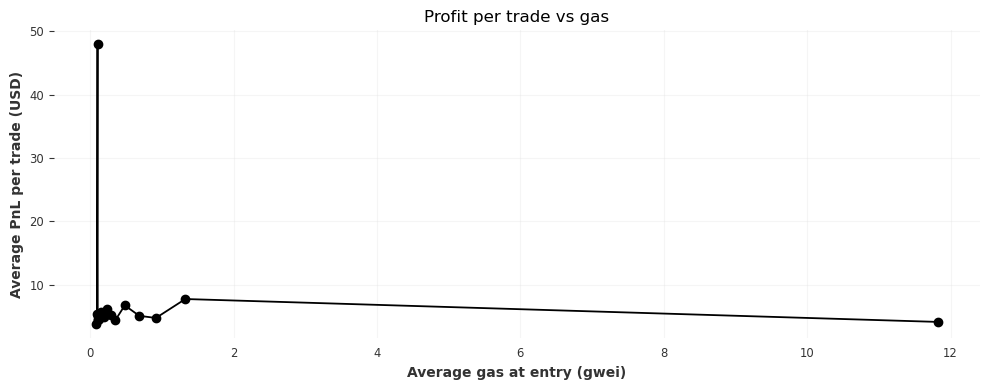

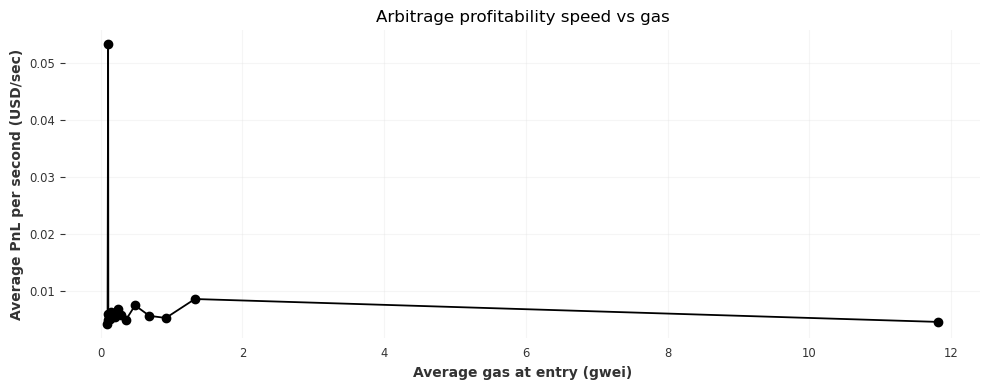

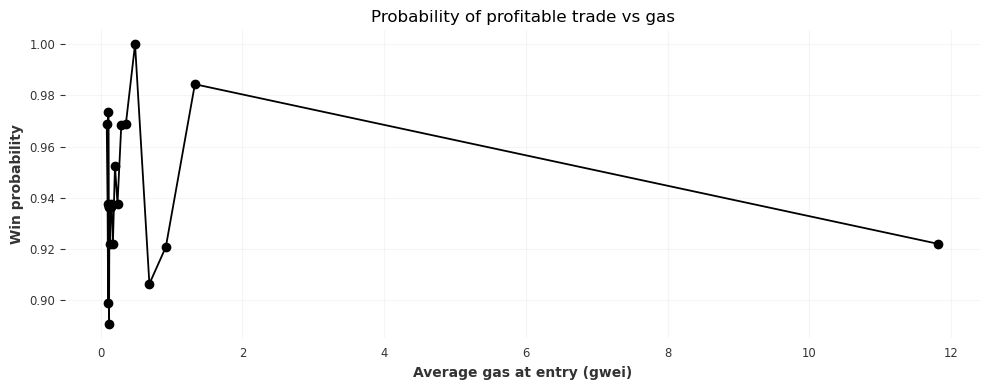

In [111]:
x = profit_by_gas['avg_gas']

# 1) Profit per trade vs gas
plt.figure(figsize=(10,4))
plt.plot(x, profit_by_gas['avg_pnl'], marker='o')
plt.xlabel('Average gas at entry (gwei)')
plt.ylabel('Average PnL per trade (USD)')
plt.title('Profit per trade vs gas')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Profit per second vs gas
plt.figure(figsize=(10,4))
plt.plot(x, profit_by_gas['avg_pnl_per_sec'], marker='o')
plt.xlabel('Average gas at entry (gwei)')
plt.ylabel('Average PnL per second (USD/sec)')
plt.title('Arbitrage profitability speed vs gas')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Winrate vs gas
plt.figure(figsize=(10,4))
plt.plot(x, profit_by_gas['winrate'], marker='o')
plt.xlabel('Average gas at entry (gwei)')
plt.ylabel('Win probability')
plt.title('Probability of profitable trade vs gas')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()